# Load gripper data and obj data

In [458]:
import os
import pandas as pd
import numpy as np
from glob import glob

def load_gripper_and_obj_trajectories_full(base_dir, triangulation = 'leastereo'):
    '''
    This function look for the demos in base_dir, and load the ndi file and marker_3d file. 
    
    Parameters
    ----------
    base_dir: string
        The path to the folder where all the demonstrations are saved.
    triangulation: string
        'leastereo' or 'dlc3d', which corresponds to which triangulation method is used to get the
        
    Returns
    -------
    gripper_traj: dict
        A dictionary whose keys are the demonstraions' ids. 
        The values are the dataframes of the corersponding
        demonstration's gripper trajectory data in ndi reference frame.
    obj_traj: dict
        A dictionary whose keys are the demonstraions' ids. The values are the dataframes of the corersponding
        demonstration's objects' pose trajectories in camera reference frame.
    '''
    demos = os.listdir(base_dir)
    gripper_trajs = {}
    markers_trajs = {}
    for demo in demos:
        demo_dir = os.path.join(base_dir, demo)
        root, dirs, files = next(os.walk(demo_dir))
        if demo == 'transformations':
            continue
        ndi_file = glob(os.path.join(demo_dir, '*NDI*'))[0]
        markers_traj_file = os.path.join(demo_dir, triangulation, 'markers_trajectory_3d.h5')

        # Open NDI file and extract the parts corresponding to the queried action
        df_temp1 = pd.read_csv(ndi_file)
        gripper_trajs[demo] = df_temp1
        
        df_temp2 = pd.read_hdf(markers_traj_file)
        markers_trajs[demo] = df_temp2.droplevel('scorer', axis = 1)
    return gripper_trajs, markers_trajs


def get_gripper_and_obj_trajectories_for_ith_action(dfs_ndi, dfs_camera, basedir, i = 0):
    '''
    Given the gripper trajs and markers_trajs loaded, this function will go in basedir and look for the Servo file
    to chunk the trajs and output the ith action's trajs.
    
    Parameters
    ---------
    dfs_ndi: dict
        A directory that contains the full gripper trajectories for different demos.
    dfs_camera: dict
        A directory that contains the full object markers trajectories for different demos.
    basedir: string
        The path to the directory that contains the demos
    i: int
        The index of the action
    '''
    gripper_trajs = {}
    markers_trajs = {}
    for demo in dfs_ndi:
        df_ndi = dfs_ndi[demo]
        df_camera = dfs_camera[demo]
        demo_dir = os.path.join(base_dir, demo)
        root, dirs, files = next(os.walk(demo_dir))
        if demo == 'transformations' or demo == '364642':
            continue
        servo_file = glob(os.path.join(demo_dir, '*Servo*'))[0]
        with open(servo_file, 'r') as f:
            lines = f.readlines()
            t_start = float(lines[1 + i].split(',')[0])
            t_end = float(lines[2 + i].split(',')[0])
        duration = t_end - t_start
        idx_start = df_ndi['Time'].sub(t_start).abs().idxmin()
        idx_end = df_ndi['Time'].sub(t_end).abs().idxmin()
        df_gripper = df_ndi.copy()[idx_start: idx_end]
        # Set the time to start from 0
        df_gripper.loc[:, 'Time'] = df_gripper.loc[:, 'Time'] - df_gripper.loc[:, 'Time'].iloc[0]
        gripper_trajs[demo] = df_gripper
        
        idx_start_obj = int(len(df_camera) * idx_start / len(df_ndi))
        idx_end_obj = int(len(df_camera) * idx_end / len(df_ndi))
        df_markers = df_camera[idx_start_obj: idx_end_obj].reset_index(drop=True)
        df_markers.loc[:,'Time'] = np.arange(len(df_markers))/len(df_markers)*duration
        markers_trajs[demo] = df_markers
    return gripper_trajs, markers_trajs
    
base_dir = '/home/luke/Desktop/project/make_tea/Process_data/postprocessed/2022-05-26'

triangulation = 'dlc3d'
gripper_trajs_in_ndi_full, obj_trajs_in_camera_full = load_gripper_and_obj_trajectories_full(base_dir, triangulation = triangulation )
gripper_trajs_in_ndi, obj_trajs_in_camera = get_gripper_and_obj_trajectories_for_ith_action(gripper_trajs_in_ndi_full, obj_trajs_in_camera_full,basedir = base_dir)

# Plot original gripper trajs in ndi reference frame

<IPython.core.display.Javascript object>


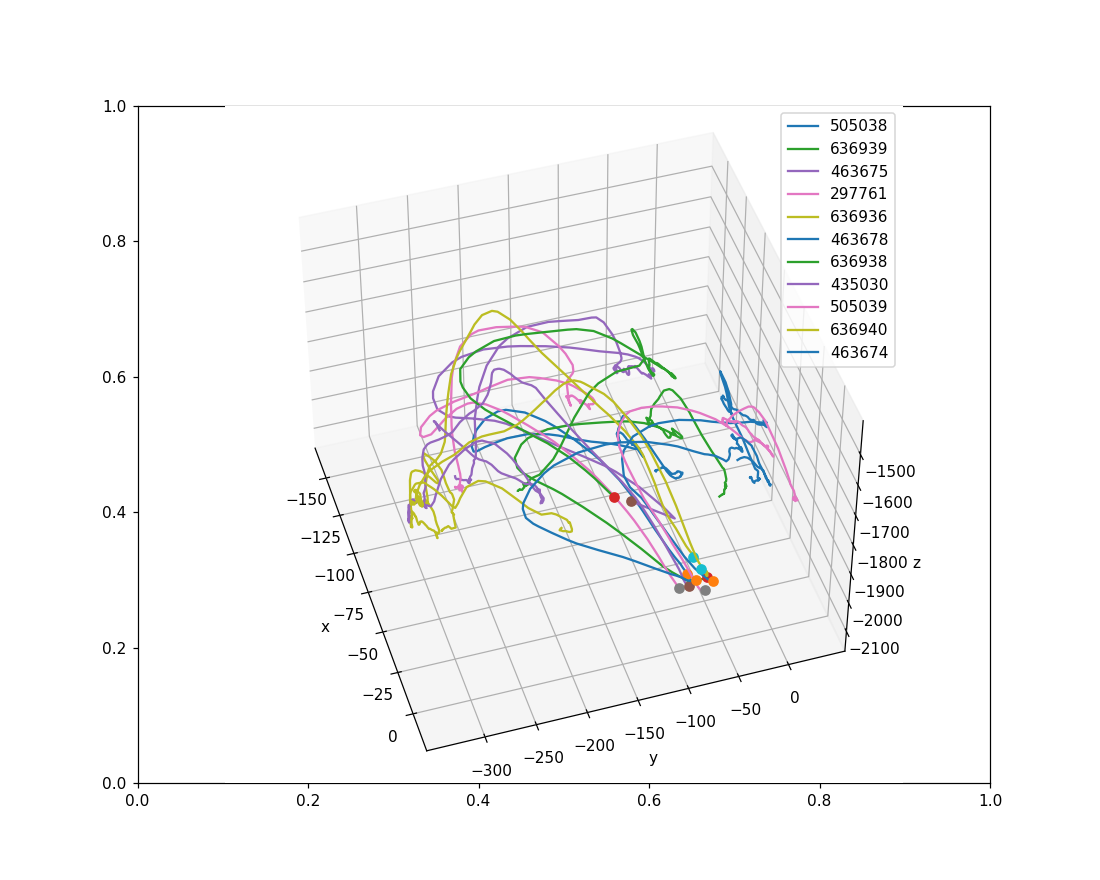

In [495]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots(1,1, figsize = (10,8))
ax = plt.axes(projection='3d')
bad_demos = []
for demo in gripper_trajs_in_ndi:
    if demo in bad_demos:
        continue
    gripper_traj = gripper_trajs_in_ndi[demo].loc[:,['x', 'y', 'z']].to_numpy()
    gripper_in_obj = gripper_traj
    
    ax.plot(gripper_in_obj[:, 0], gripper_in_obj[:, 1], gripper_in_obj[:, 2], label = f'{demo}')
    ax.plot(gripper_in_obj[0, 0], gripper_in_obj[0, 1], gripper_in_obj[0, 2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Apply DTW

In [404]:
from dtw_util import *

demos = [demo for demo in gripper_trajs_in_ndi.keys() if demo not in bad_demos]
num_demos = len(demos)
trajs_len = []
normalized_demos = {}
for demo in demos:
    df = gripper_trajs_in_ndi[demo]
    time_diff = df['Time'].diff(1)
    temp = ((np.sqrt(np.square(df.loc[:, ['x','y','z']].diff(1)).sum(axis=1))))/time_diff
    gripper_trajs_in_ndi[demo]['Speed'] = np.array(temp)
    gripper_trajs_in_ndi[demo].dropna(inplace=True)
    trajs_len.append(len(gripper_trajs_in_ndi[demo]))
# get demos with median duration
median_len_ind = trajs_len.index(int(np.median(trajs_len)))
median_len_demo = demos[median_len_ind]

ref_demo_speed = gripper_trajs_in_ndi[median_len_demo]['Speed'].to_numpy()
ref_demo_traj = gripper_trajs_in_ndi[median_len_demo][['Time', 'x', 'y', 'z', 'Rx', 'Ry', 'Rz']]
min_cost_demos = {}
for demo in demos:
    test_demo_speed = gripper_trajs_in_ndi[demo]['Speed'].to_numpy()
    test_demo_traj = gripper_trajs_in_ndi[demo][['Time', 'x', 'y', 'z', 'Rx', 'Ry', 'Rz']].copy().to_numpy()
    match_indices, min_cost = dynamic_time_warp(ref_demo_speed, test_demo_speed)
    match_indices = np.array(match_indices)
    min_cost_demos[demo] = min_cost
    new_demo = np.zeros(ref_demo_traj.shape)
    for match in match_indices:
        new_demo[match[0]-1] = test_demo_traj[match[1]-1]
    normalized_demos[demo] = new_demo

<IPython.core.display.Javascript object>


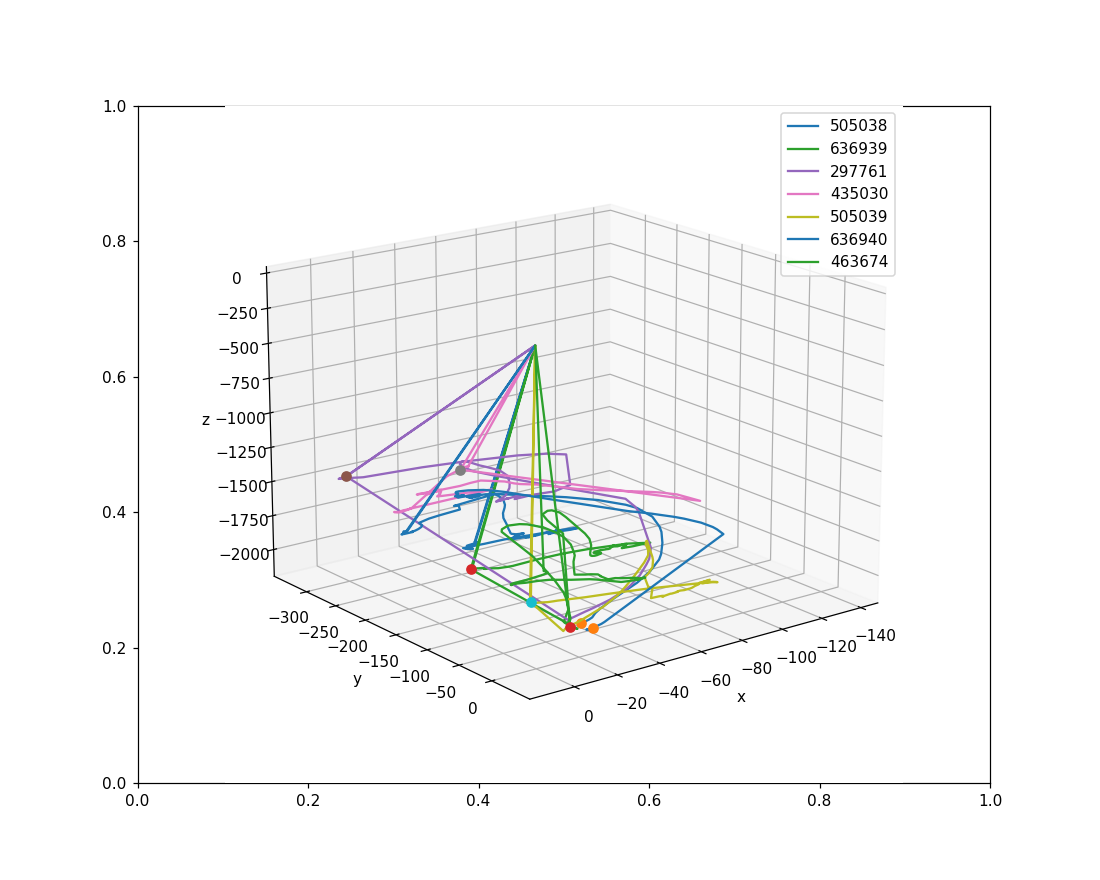

In [406]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots(1,1, figsize = (10,8))
ax = plt.axes(projection='3d')
for demo in normalized_demos:
    gripper_traj = normalized_demos[demo][:,1:4]
    gripper_in_obj = gripper_traj
    ax.plot(gripper_in_obj[:, 0], gripper_in_obj[:, 1], gripper_in_obj[:, 2], label = f'{demo}')
    ax.plot(gripper_in_obj[0, 0], gripper_in_obj[0, 1], gripper_in_obj[0, 2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Convert gripper trajs from ndi to obj reference frame

In [547]:

import pickle
from itertools import combinations

def homogenous_transform(R,vect):

    '''
    :param R: 3x3 matrix
    :param vect: list x,y,z
    :return:Homogenous transformation 4x4 matrix using R and vect
    '''

    H = np.zeros((4,4))
    H[0:3,0:3] = R
    frame_displacement = vect + [1]
    D = np.array(frame_displacement)
    D.shape = (1,4)
    H[:,3] = D
    return H

def inverse_homogenous_transform(H):

    '''
    :param H: Homogenous Transform Matrix
    :return: Inverse Homegenous Transform Matrix
    '''


    R = H[0:3,0:3]
    origin = H[:-1,3]
    origin.shape = (3,1)

    R = R.T
    origin = -R.dot(origin)
    return homogenous_transform(R,list(origin.flatten()))

def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

#     special reflection case
    if np.linalg.det(R) < 0:
#         print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def get_HT_template_in_obj(template, obj_coord, camera_in_template):
    '''
    This function will align the object with template and output the homogeneous transformation 
    and the markers' average distance
    
    Parameters
    ----------
    template: dict
        The obj template that has the markers position in camera reference frame
    obj_coord: dict
        The dict that contains the marker's coordinates in camera reference frame for a frame of the video
    camera_in_template: np.array
        A 4 by 4 array that represents camera in the template's reference frame
        
    Returns
    -------
    template_in_obj: np.array
        A 4 by 4 homogeneous transformation that represents template in the object's reference frame
    dist: float
        The lowest average markers' distance after aligning object with the template
    
    '''
    idx = pd.IndexSlice
    points_template = []
    points_obj = []
    if not isinstance(obj_coord, dict):
        bps = obj_coord.index.get_level_values('bodyparts').unique()
        for bodypart in bps:
            df_bodypart = obj_coord.loc[bodypart]
            if not df_bodypart.isnull().values.any():
                points_template.append(template[bodypart])
                points_obj.append(df_bodypart.to_numpy())
    else:
        keys = obj_coord.keys()
        for bodypart in keys:
            df_bodypart = df[bodypart]
            if not df_bodypart.isnull().values.any():
                points_template.append(template[bodypart])
                points_obj.append(df_bodypart.to_numpy())
                
    points_template = np.array(points_template).T
    points_obj = np.array(points_obj).T
    
    points_template_in_template = camera_in_template @ homogenous_position(points_template)
    points_obj_in_template = camera_in_template @ homogenous_position(points_obj)
    rotmatrix, translation = rigid_transform_3D(points_obj_in_template[:3,:], points_template_in_template[:3,:])
    H = homogenous_transform(rotmatrix, list(translation.flatten()))
    
    points_obj_transformed = (H @ points_obj_in_template).T
    dists = []
    for i, point in enumerate(points_obj_transformed):
        point = point[:3]
        dist = np.linalg.norm(point[:3] - points_template_in_template[:-1,i])
        dists.append(dist)
    dist_average = np.mean(np.array(dists), axis=0)
#     print(f'distances : {dists}')
#     print(f'average distance: {dist_average}')
    return H, dist_average


def homogenous_position(vect):
    '''
    This function will make sure the coordinates in the right shape(4 by N) that could be multiplied by a
    homogeneous transformation(4 by 4).
    
    Parameters
    ----------
    vect: list or np.array
        A 3 by N array. x, y, z coordinates of the N points
        
    Return 
    ------
    A 4 by N array.
    '''
    temp = np.array(vect)
    if temp.ndim == 1:
        ones = np.ones(1)
        return np.r_[temp, ones].reshape(-1, 1)
    elif temp.ndim == 2:
        
        num_rows, num_cols = temp.shape
        if num_rows != 3:
            raise Exception(f"vect is not 3 * N, it is {num_rows}x{num_cols}")

        ones = np.ones(num_cols).reshape(1,-1)
        return np.r_[temp, ones]


def get_matched_marker_coords(obj_template, df_individual, camera_in_template, window_size, n_marker = 3):
    '''
    Search the first window_size rows of df_individual so that it matches the obj_template the best.
    
    Parameters
    ----------
    obj_template: dict
        The obj template that has the markers position in camera reference frame
    df_individual: Dataframe
        The Dataframe that contains the DLC + LEAstereo output for an individual
    camera_in_template: np.array
        A 4 by 4 array that represents camera in the template's reference frame
    window_size: int
        The first window_size rows that will be searched to find the best row
    n_marker: int
        The number of markers that will be used to align object with template.
        
    Returns
    -------
    template_in_obj: np.array
        A 4 by 4 homogeneous transformation that represents template in the object's reference frame
    dist: float
        The lowest average markers' distance after aligning object with the template
    
    '''
    dist = np.inf
    for i in range(window_size):
        marker_coords = df_individual.iloc[i]
        bps = marker_coords.index.get_level_values('bodyparts').unique()
        combs = combinations(bps, n_marker)
        for comb in combs:
            partial_marker_coords = marker_coords.loc[list(comb)]
            if partial_marker_coords.isnull().any():
                continue
            H, dist_average = get_HT_template_in_obj(obj_template, partial_marker_coords, camera_in_template)
            if dist_average < dist:
                dist = dist_average
                template_in_obj = H
    return template_in_obj, dist

individuals = ['global', 'teabag1', 'teabag2', 'cup', 'pitcher', 'tap']
bad_demos = ['463678', '636936', '636938', '463675']

'''
'463678', '636936': mislabeled teabag1
'636938', '463675': starting point far from other demos
'''
gripper_trajs_in_obj = {individual :{} for individual in individuals}
template_dir = f'/home/luke/Desktop/project/make_tea/Process_data/postprocessed/2022-05-26/transformations/{triangulation}'
with open(os.path.join(template_dir, 'obj_templates.pickle'), "rb") as f:
    obj_templates = pickle.load(f)
with open(os.path.join(template_dir, 'camera_to_ndi.pickle'), "rb") as f:
    camera_in_ndi = pickle.load(f)
with open(os.path.join(template_dir, 'ndi_to_camera.pickle'), "rb") as f:
    ndi_in_camera = pickle.load(f)

demos = [demo for demo in gripper_trajs_in_ndi]
obj_pos_in_ndi = {demo: {} for demo in demos}

for individual in individuals:
    if 'teabag' in individual:
        obj = 'teabag'
    elif individual == 'global':
        for demo in gripper_trajs_in_ndi.keys():
            gripper_trajs_in_obj[individual][demo] = gripper_trajs_in_ndi[demo]
            obj_pos_in_ndi[demo][individual] = np.array([0,0,0])
        continue
    else:
        obj = individual
    obj_template = obj_templates[obj]
    rot_matrix = ndi_in_camera[:3,:3]

    markers = []
    for bp in obj_template:
        markers.append(obj_template[bp])
    markers = np.array(markers)
    center = np.mean(markers, axis=0)
    template_in_camera = homogenous_transform(rot_matrix, list(center))
    camera_in_template = inverse_homogenous_transform(template_in_camera)
    for demo in obj_trajs_in_camera:
        dists = {}
        df_individual = obj_trajs_in_camera_full[demo][individual]
        template_in_obj, dist = get_matched_marker_coords(obj_template, df_individual, camera_in_template, window_size)
        dists[demo] = dist
        if dist > 20:
            bad_demos.append(demo)
        if demo in bad_demos:
            continue
        gripper_traj = gripper_trajs_in_ndi[demo].loc[:,['x', 'y', 'z']].to_numpy()
        obj_in_template = inverse_homogenous_transform(template_in_obj)
#         obj_in_camera = template_in_camera @ obj_in_template
        obj_in_ndi = camera_in_ndi @ template_in_camera @ obj_in_template
        obj_in_ndi[:3, :3] = np.eye(3)
        obj_pos_in_ndi[demo][individual] = obj_in_ndi[:-1, 3]
        ndi_in_obj = inverse_homogenous_transform(obj_in_ndi)
        
        gripper_in_obj = (ndi_in_obj @ homogenous_position(gripper_traj.T)).T[:,:-1]
        gripper_traj_in_obj = gripper_trajs_in_ndi[demo].copy()
        gripper_traj_in_obj[['x', 'y', 'z']] = gripper_in_obj
        gripper_trajs_in_obj[individual][demo] = gripper_traj_in_obj

# Plot trajs in obj frame

<IPython.core.display.Javascript object>


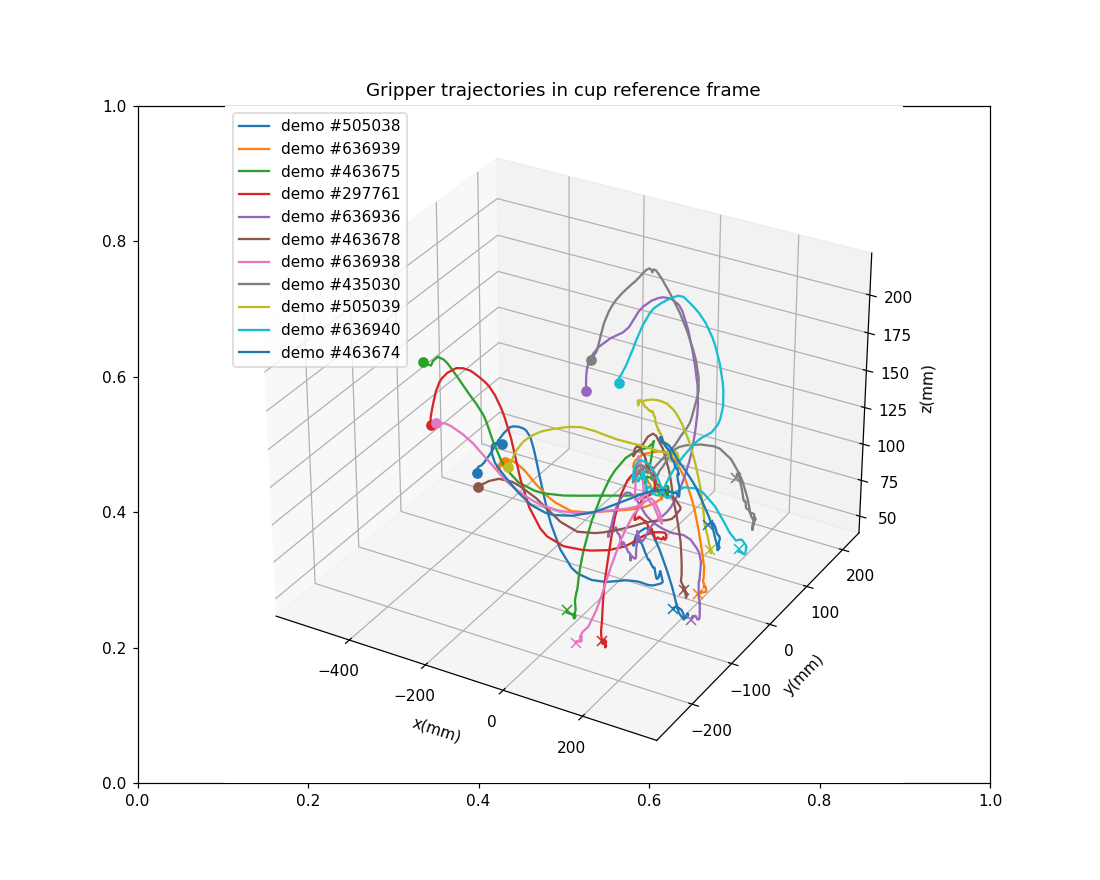

In [540]:
import robpy.full_promp as promp
import robpy.utils as utils
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook


fig,ax = plt.subplots(1,1, figsize = (10,8))

individual = 'cup'

data = gripper_trajs_in_obj
ax = plt.axes(projection='3d')
for demo in data[individual]:
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()

# Filter data

In [541]:
from scipy import ndimage
# A Gaussian filter is used to get the trajectories smoother so that it is easier to learn
gripper_trajs_in_obj_filtered = {individual :{} for individual in individuals}
sigma = 0
sigma = [sigma, 0]
for individual in individuals:
    for demo in gripper_trajs_in_obj[individual]:
        q = gripper_trajs_in_obj[individual][demo].loc[:, ['x', 'y', 'z']]
        q_filtered = ndimage.gaussian_filter(q, sigma = sigma)
        temp = gripper_trajs_in_obj[individual][demo].copy()
        temp.loc[:, ['x', 'y', 'z']] = q_filtered
        gripper_trajs_in_obj_filtered[individual][demo] = temp
        

# Plot filtered trajectories with bad demos removed

<IPython.core.display.Javascript object>


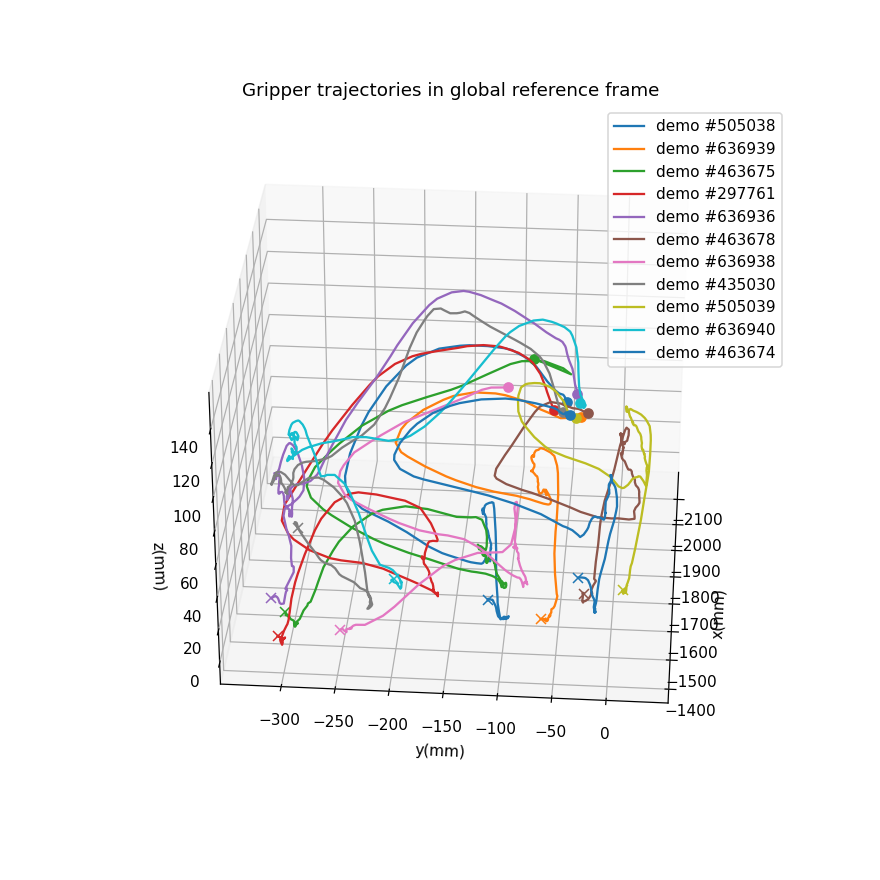

In [542]:
individual = 'global'

'''
teabag1 is incorrectly labeld for demos: '505039', '463678'
something is wrong with tap: '636938'
something is wrong with pitcher: '463675'
'''
plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

data = gripper_trajs_in_obj_filtered
for demo in data[individual]:
    if demo in bad_demos:
        continue
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()

# Train ProbMPs

In [565]:
import random

sig = 0.035 # The standard deviation of the Gaussian functions
# Define the basis functions
full_basis = {
        'conf': [
                {"type": "sqexp", "nparams": 22, "conf": {"dim": 21}},
            {"type": "poly", "nparams": 0, "conf": {"order": 1}},
            {"type": "poly", "nparams": 0, "conf": {"order": 2}},
            {"type": "poly", "nparams": 0, "conf": {"order": 3}}
            ],
        'params': [np.log(sig),0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65
                   ,0.7,0.75,0.8,0.85,0.9,0.95,1]
        }

individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2', 'global']
# Each individual will have its own promp model
promps = {individual : promp.FullProMP(basis=full_basis) for individual in individuals}


#3) Train ProMP with NIW prior on the covariance matrix (as described in the paper)
bad_demos = ['463678', '636936', '636938', '463675']
gripper_trajs_in_obj_filtered_train = {individual: {'coords':[], 'time':[]} for individual in individuals}
demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
train_demos = random.sample(demos, k=6)

for individual in individuals:
    for d in train_demos:
        t = gripper_trajs_in_obj_filtered[individual][d]['Time'].to_numpy().flatten()
        t = t / t[-1]
        gripper_trajs_in_obj_filtered_train[individual]['coords'].append(
            gripper_trajs_in_obj_filtered[individual][d].loc[:,['x', 'y','z']].to_numpy())
        gripper_trajs_in_obj_filtered_train[individual]['time'].append(t)

dof = 3
dim_basis_fun = 30
inv_whis_mean = lambda v, Sigma: 9e-1*utils.make_block_diag(Sigma, dof) + 1e-1*np.eye(dof*dim_basis_fun)
prior_Sigma_w = {'v':dim_basis_fun*dof, 'mean_cov_mle': inv_whis_mean}
for individual in individuals:
    Q = gripper_trajs_in_obj_filtered_train[individual]['coords']
    times = gripper_trajs_in_obj_filtered_train[individual]['time']
    train_summary = promps[individual].train(times, q = Q, max_iter=30, prior_Sigma_w=prior_Sigma_w,
            print_inner_lb=True)

lb(mu_w)= -4733916.778011213
lb(Sigma_w)= -81661.18486211654
lb(Sigma_y)= -20287.84201824274
lb(mu_w)= -21862.479049700807
lb(Sigma_w)= -21206.88514145238
lb(Sigma_y)= -21159.90050569448
lb(mu_w)= -22299.13563663268
lb(Sigma_w)= -21613.380078147537
lb(Sigma_y)= -21609.206474906023
lb(mu_w)= -22482.428906522982
lb(Sigma_w)= -21841.65325745038
lb(Sigma_y)= -21838.130148555872
lb(mu_w)= -22538.87911631067
lb(Sigma_w)= -21951.296833130407
lb(Sigma_y)= -21948.451220708255
lb(mu_w)= -22532.195508870238
lb(Sigma_w)= -21996.307482597775
lb(Sigma_y)= -21994.2403547409
lb(mu_w)= -22494.98886709954
lb(Sigma_w)= -22005.95061633378
lb(Sigma_y)= -22004.51257017974
lb(mu_w)= -22443.237945264456
lb(Sigma_w)= -21996.159203443152
lb(Sigma_y)= -21995.15339929318
lb(mu_w)= -22384.787524590047
lb(Sigma_w)= -21975.765987912004
lb(Sigma_y)= -21975.041477142688
lb(mu_w)= -22323.879427231983
lb(Sigma_w)= -21949.80129980633
lb(Sigma_y)= -21949.260940387856
lb(mu_w)= -22263.05462069827
lb(Sigma_w)= -21921.210234

lb(mu_w)= -21664.84759099762
lb(Sigma_w)= -21590.59659490988
lb(Sigma_y)= -21590.56926665425
lb(mu_w)= -21649.552334801658
lb(Sigma_w)= -21580.36644977919
lb(Sigma_y)= -21580.342049992192
lb(mu_w)= -4668277.301465256
lb(Sigma_w)= -81897.48751212476
lb(Sigma_y)= -20304.573153330944
lb(mu_w)= -21836.8202845185
lb(Sigma_w)= -21203.618524430556
lb(Sigma_y)= -21147.114949429044
lb(mu_w)= -22269.365047967745
lb(Sigma_w)= -21600.068809685195
lb(Sigma_y)= -21595.938093637145
lb(mu_w)= -22461.847487551044
lb(Sigma_w)= -21830.577261956278
lb(Sigma_y)= -21827.45025183673
lb(mu_w)= -22524.936933588608
lb(Sigma_w)= -21944.36518184762
lb(Sigma_y)= -21941.93005467068
lb(mu_w)= -22523.90806520621
lb(Sigma_w)= -21993.888264511836
lb(Sigma_y)= -21992.115041744535
lb(mu_w)= -22491.55779938328
lb(Sigma_w)= -22007.48141313201
lb(Sigma_y)= -22006.21926909033
lb(mu_w)= -22443.70110474777
lb(Sigma_w)= -22000.76987478252
lb(Sigma_y)= -21999.86099574229
lb(mu_w)= -22388.212735176352
lb(Sigma_w)= -21982.61917177

lb(mu_w)= -22249.19575294903
lb(Sigma_w)= -22178.790923951616
lb(Sigma_y)= -22178.72576121134
lb(mu_w)= -22229.303645824155
lb(Sigma_w)= -22163.641425763883
lb(Sigma_y)= -22163.580272813626
lb(mu_w)= -22210.428374171584
lb(Sigma_w)= -22149.058248751062
lb(Sigma_y)= -22149.00071544792
lb(mu_w)= -22192.483212882355
lb(Sigma_w)= -22135.006636826423
lb(Sigma_y)= -22134.95240050891


# Plot samples after training

<IPython.core.display.Javascript object>


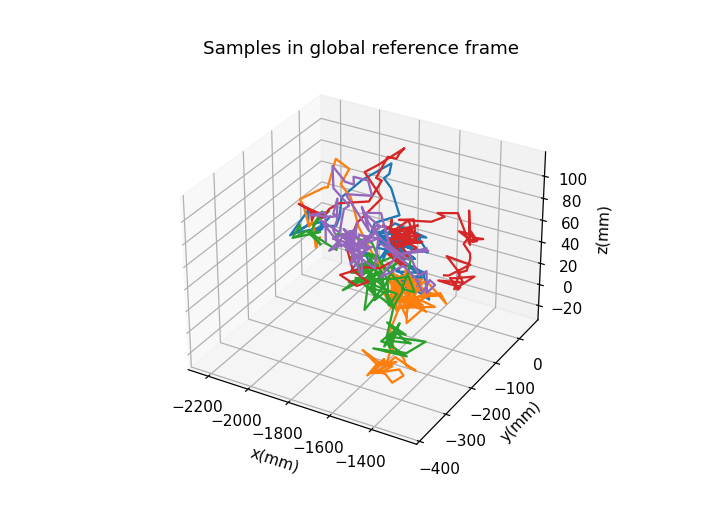

In [567]:
#4) Plot some samples from the learned ProMP and conditioned ProMP

n_samples = 5 # Number of samples to draw
plot_dof = 1 # Degree of freedom to plot
sample_time = [np.linspace(0,1,100) for i in range(n_samples)]

#4.1) Make some samples from the unconditioned ProMP
individual = 'global'
promp_samples = promps[individual].sample(sample_time)
plt.figure()
ax = plt.axes(projection='3d')
for t,q in zip(sample_time, promp_samples):
    if q.shape[1] == 1:
        plt.plot(np.array(t) - t[0],q[:,0])
    else:
        ax.plot(q[:,2], q[:,1], - q[:,0])
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        ax.set_title(f'Samples in {individual} reference frame')
plt.show()

<IPython.core.display.Javascript object>


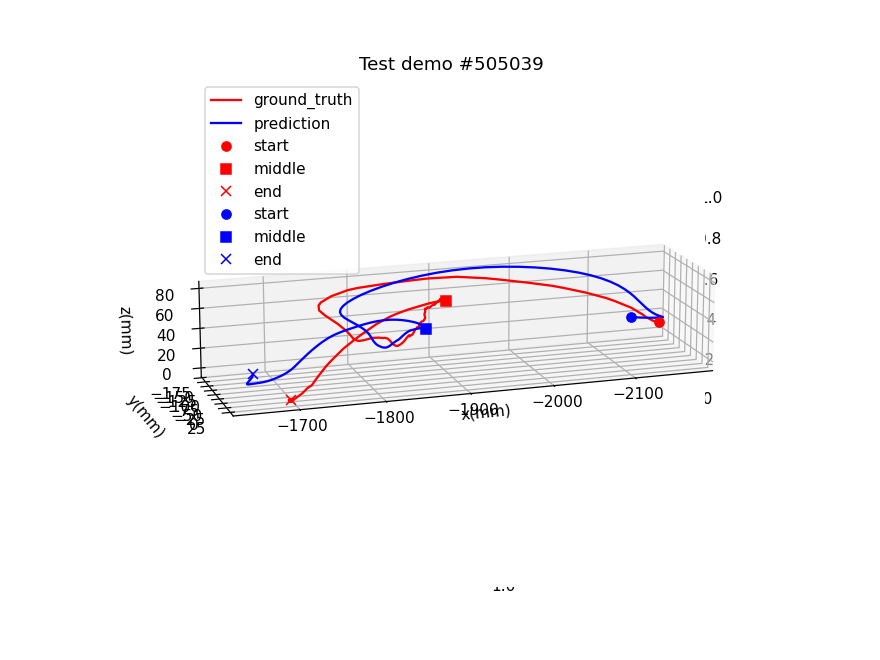

This distance at the start point is 35.252523154620555 mm
This distance at the middle point is 38.17806627645242 mm
This distance at the end point is 93.27525513485107 mm


In [579]:
def get_mean_cov_hats(ref_means, ref_covs, min_len=None):
    sigma_hats, ref_pts = [], len(ref_means)
    if not min_len:
        min_len = min([len(r) for r in ref_means])
    # solve for global covariance
    for p in range(min_len):
        covs = [cov[p] for cov in ref_covs]
        inv_sum = np.linalg.inv(covs[0])
        for ref in range(1, ref_pts):
            inv_sum = inv_sum + np.linalg.inv(covs[ref])
        sigma_hat = np.linalg.inv(inv_sum)
        sigma_hats.append(sigma_hat)

    mean_hats = []
    for p in range(min_len):
        mean_w_sum = np.matmul(np.linalg.inv(ref_covs[0][p]), ref_means[0][p])
        for ref in range(1, ref_pts):
            mean_w_sum = mean_w_sum + np.matmul(np.linalg.inv(ref_covs[ref][p]), ref_means[ref][p])
        mean_hats.append(np.matmul(sigma_hats[p], mean_w_sum))
    return np.array(mean_hats), np.array(sigma_hats)

test_demos = [demo for demo in demos if demo not in train_demos and demo not in bad_demos]

for demo in test_demos:
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        translation = obj_pos_in_ndi[demo][individual]
        mean_global = mean + translation
        
        means_objs_global.append(mean_global)
        covs_objs_global.append(cov)

    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    
    plt.figure(figsize = (8,6))
    ax = plt.axes(projection='3d')
    ax = plt.axes(projection='3d')
    ax.plot(ground_truth[:,2], ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
    ax.plot(mean_hats[:,2], mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
    ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
    ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
    ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
    ax.plot(mean_hats[0,2], mean_hats[0,1], -mean_hats[0,0],'bo', label = 'start')
    ax.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], -mean_hats[mid_ind,0],'bs', label = 'middle')
    ax.plot(mean_hats[-1,2], mean_hats[-1,1], -mean_hats[-1,0],'bx', label = 'end')
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
#     ax.set_aspect('equal')
    ax.set_box_aspect((np.ptp(ground_truth[:,2]), np.ptp(ground_truth[:,1]), np.ptp(-ground_truth[:,0])))
    ax.set_title(f'Test demo #{demo}')
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:] - mean_hats[mid_ind,:])
    dist_start = np.linalg.norm(ground_truth[0,:] - mean_hats[0,:])
    dist_end = np.linalg.norm(ground_truth[-1,:] - mean_hats[-1,:])
    print(f'This distance at the start point is {dist_start} mm')
    print(f'This distance at the middle point is {dist_mid} mm')
    print(f'This distance at the end point is {dist_end} mm')
    plt.legend()
#     plt.show()


# Run many tests and see the average result

In [559]:
n_test = 20
# bad_demos = []
# bad_demos = ['463678', '636936'] # demos with mislabeld teabag1
# bad_demos = ['636938', '463675'] # demos that starts late
bad_demos = ['463678', '636936', '636938', '463675']
dists = []
for i in range(n_test):
    sig = 0.035 # The standard deviation of the Gaussian functions
    # Define the basis functions
    full_basis = {
            'conf': [
                    {"type": "sqexp", "nparams": 22, "conf": {"dim": 21}},
                {"type": "poly", "nparams": 0, "conf": {"order": 1}},
                {"type": "poly", "nparams": 0, "conf": {"order": 2}},
                {"type": "poly", "nparams": 0, "conf": {"order": 3}}
                ],
            'params': [np.log(sig),0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65
                       ,0.7,0.75,0.8,0.85,0.9,0.95,1]
            }

    individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']
    # Each individual will have its own promp model
    promps = {individual : promp.FullProMP(basis=full_basis) for individual in individuals}


    #3) Train ProMP with NIW prior on the covariance matrix (as described in the paper)

    gripper_trajs_in_obj_filtered_train = {individual: {'coords':[], 'time':[]} for individual in individuals}
    demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
    train_demos = random.sample(demos, k=6)
    test_demos = [demo for demo in demos if demo not in train_demos and demo not in bad_demos]

    for individual in individuals:
        for d in train_demos:
            t = gripper_trajs_in_obj_filtered[individual][d]['Time'].to_numpy().flatten()
            t = t / t[-1]
            gripper_trajs_in_obj_filtered_train[individual]['coords'].append(
                gripper_trajs_in_obj_filtered[individual][d].loc[:,['x', 'y','z']].to_numpy())
            gripper_trajs_in_obj_filtered_train[individual]['time'].append(t)

    dof = 3
    dim_basis_fun = 30
    inv_whis_mean = lambda v, Sigma: 9e-1*utils.make_block_diag(Sigma, dof) + 1e-1*np.eye(dof*dim_basis_fun)
    prior_Sigma_w = {'v':dim_basis_fun*dof, 'mean_cov_mle': inv_whis_mean}
    for individual in individuals:
        Q = gripper_trajs_in_obj_filtered_train[individual]['coords']
        times = gripper_trajs_in_obj_filtered_train[individual]['time']
        train_summary = promps[individual].train(times, q = Q, max_iter=30, prior_Sigma_w=prior_Sigma_w,
                print_inner_lb=True)

    demo = random.choice(test_demos)
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        translation = obj_pos_in_ndi[demo][individual]
        mean_global = mean + translation

        means_objs_global.append(mean_global)
        covs_objs_global.append(cov)

    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:] - mean_hats[mid_ind,:])
    dist_start = np.linalg.norm(ground_truth[0,:] - mean_hats[0,:])
    dist_end = np.linalg.norm(ground_truth[-1,:] - mean_hats[-1,:])
    
    dists.append([dist_start, dist_mid, dist_end])

lb(mu_w)= -4456461.8629614
lb(Sigma_w)= -72315.6956455459
lb(Sigma_y)= -19581.504468640527
lb(mu_w)= -21206.894541260077
lb(Sigma_w)= -20435.441644393508
lb(Sigma_y)= -20371.91495889663
lb(mu_w)= -21543.52050372239
lb(Sigma_w)= -20777.263739526818
lb(Sigma_y)= -20772.50517945729
lb(mu_w)= -21608.32264082923
lb(Sigma_w)= -20976.514143335284
lb(Sigma_y)= -20973.67446407152
lb(mu_w)= -21630.488024040398
lb(Sigma_w)= -21075.302523772618
lb(Sigma_y)= -21073.411745596153
lb(mu_w)= -21626.3427144209
lb(Sigma_w)= -21118.824269271077
lb(Sigma_y)= -21117.502495501947
lb(mu_w)= -21599.049806831357
lb(Sigma_w)= -21130.28517125283
lb(Sigma_y)= -21129.307787196365
lb(mu_w)= -21554.883263215652
lb(Sigma_w)= -21122.815701138996
lb(Sigma_y)= -21122.06514667982
lb(mu_w)= -21500.434266934804
lb(Sigma_w)= -21104.38697214945
lb(Sigma_y)= -21103.799007368252
lb(mu_w)= -21441.031424322082
lb(Sigma_w)= -21080.00016189812
lb(Sigma_y)= -21079.534975308845
lb(mu_w)= -21380.48207781229
lb(Sigma_w)= -21052.8193265

lb(mu_w)= -20867.927086157484
lb(Sigma_w)= -20804.87836502218
lb(Sigma_y)= -20804.857117059575
lb(mu_w)= -20855.52466063863
lb(Sigma_w)= -20797.017263115165
lb(Sigma_y)= -20796.998387854874
lb(mu_w)= -4432300.682817746
lb(Sigma_w)= -72517.28088333373
lb(Sigma_y)= -19605.81959606281
lb(mu_w)= -21229.65353027381
lb(Sigma_w)= -20473.57754204119
lb(Sigma_y)= -20411.43062832415
lb(mu_w)= -21532.177036759138
lb(Sigma_w)= -20810.31776129089
lb(Sigma_y)= -20805.028034874776
lb(mu_w)= -21614.07983749678
lb(Sigma_w)= -21004.924000776762
lb(Sigma_y)= -21001.983219897935
lb(mu_w)= -21646.411322643846
lb(Sigma_w)= -21101.42133906526
lb(Sigma_y)= -21099.508302966417
lb(mu_w)= -21645.278402184904
lb(Sigma_w)= -21143.626284796374
lb(Sigma_y)= -21142.291716476364
lb(mu_w)= -21618.30927347033
lb(Sigma_w)= -21154.186213133977
lb(Sigma_y)= -21153.200709872697
lb(mu_w)= -21573.814471675614
lb(Sigma_w)= -21146.021971258146
lb(Sigma_y)= -21145.267631916424
lb(mu_w)= -21518.996632201055
lb(Sigma_w)= -21127.01

lb(mu_w)= -21012.91408264242
lb(Sigma_w)= -20930.41164201926
lb(Sigma_y)= -20930.384403054002
lb(mu_w)= -20997.625466112087
lb(Sigma_w)= -20921.142052326002
lb(Sigma_y)= -20921.118084074737
lb(mu_w)= -20983.548061322177
lb(Sigma_w)= -20912.556130159086
lb(Sigma_y)= -20912.535014004272
lb(mu_w)= -20970.571371390328
lb(Sigma_w)= -20904.60149627523
lb(Sigma_y)= -20904.582874371612
lb(mu_w)= -4513645.418892546
lb(Sigma_w)= -83302.7507124913
lb(Sigma_y)= -19659.949843043418
lb(mu_w)= -21287.98921668328
lb(Sigma_w)= -20487.02169223349
lb(Sigma_y)= -20394.493739795253
lb(mu_w)= -21556.871392546484
lb(Sigma_w)= -20826.045688283357
lb(Sigma_y)= -20822.792902426118
lb(mu_w)= -21655.062165627925
lb(Sigma_w)= -21060.839779989863
lb(Sigma_y)= -21059.107408207972
lb(mu_w)= -21725.628541312173
lb(Sigma_w)= -21187.8130650707
lb(Sigma_y)= -21186.438921887195
lb(mu_w)= -21752.277070994664
lb(Sigma_w)= -21250.79077445885
lb(Sigma_y)= -21249.659547543997
lb(mu_w)= -21743.007834820346
lb(Sigma_w)= -21275.4

lb(Sigma_y)= -20987.49303366995
lb(mu_w)= -21071.229197033234
lb(Sigma_w)= -20975.464329260783
lb(Sigma_y)= -20975.427929865527
lb(mu_w)= -21052.884293569827
lb(Sigma_w)= -20964.276625301074
lb(Sigma_y)= -20964.24464101637
lb(mu_w)= -21036.008185513332
lb(Sigma_w)= -20953.904207065418
lb(Sigma_y)= -20953.876055623437
lb(mu_w)= -21020.463437490485
lb(Sigma_w)= -20944.285386927982
lb(Sigma_y)= -20944.26057670361
lb(mu_w)= -21006.128224676766
lb(Sigma_w)= -20935.36369541201
lb(Sigma_y)= -20935.34180776428
lb(mu_w)= -20992.89450136194
lb(Sigma_w)= -20927.0874852204
lb(Sigma_y)= -20927.06816099788
lb(mu_w)= -6468484.860308635
lb(Sigma_w)= -83821.69530035212
lb(Sigma_y)= -20179.893597401013
lb(mu_w)= -21673.676813710452
lb(Sigma_w)= -20997.62202424166
lb(Sigma_y)= -20919.227735650464
lb(mu_w)= -22135.83549213566
lb(Sigma_w)= -21383.10788093941
lb(Sigma_y)= -21379.925096928295
lb(mu_w)= -22343.177915629272
lb(Sigma_w)= -21633.028953299443
lb(Sigma_y)= -21630.898452014488
lb(mu_w)= -22412.2587

lb(mu_w)= -20890.135216804454
lb(Sigma_w)= -20788.780544275454
lb(Sigma_y)= -20788.735549491503
lb(mu_w)= -20869.53200266604
lb(Sigma_w)= -20776.421451924165
lb(Sigma_y)= -20776.38208073798
lb(mu_w)= -20850.711866730395
lb(Sigma_w)= -20765.00175608024
lb(Sigma_y)= -20764.96717004913
lb(mu_w)= -20833.488812026804
lb(Sigma_w)= -20754.44076860261
lb(Sigma_y)= -20754.410286869905
lb(mu_w)= -20817.698720590197
lb(Sigma_w)= -20744.665373254964
lb(Sigma_y)= -20744.638436934343
lb(mu_w)= -20803.197217754674
lb(Sigma_w)= -20735.609620546966
lb(Sigma_y)= -20735.585765899792
lb(mu_w)= -20789.857443185625
lb(Sigma_w)= -20727.214153192974
lb(Sigma_y)= -20727.192991386248
lb(mu_w)= -20777.567892631574
lb(Sigma_w)= -20719.425566659484
lb(Sigma_y)= -20719.406768438315
lb(mu_w)= -4424047.038851827
lb(Sigma_w)= -75275.27481801815
lb(Sigma_y)= -19694.833759376517
lb(mu_w)= -21230.83303218572
lb(Sigma_w)= -20469.02016416892
lb(Sigma_y)= -20382.254768750652
lb(mu_w)= -21488.248239805387
lb(Sigma_w)= -20788

lb(mu_w)= -21592.949433063015
lb(Sigma_w)= -21473.063103201996
lb(Sigma_y)= -21473.001511832263
lb(mu_w)= -21567.754846768858
lb(Sigma_w)= -21457.540991285372
lb(Sigma_y)= -21457.487087442703
lb(mu_w)= -21544.66585276369
lb(Sigma_w)= -21443.09515531458
lb(Sigma_y)= -21443.04766560619
lb(mu_w)= -21523.459506453182
lb(Sigma_w)= -21429.632302645296
lb(Sigma_y)= -21429.590221547474
lb(mu_w)= -21503.9363500319
lb(Sigma_w)= -21417.066706020803
lb(Sigma_y)= -21417.029232729325
lb(mu_w)= -21485.91966951425
lb(Sigma_w)= -21405.32072023122
lb(Sigma_y)= -21405.287210889943
lb(mu_w)= -21469.25393871621
lb(Sigma_w)= -21394.324680518712
lb(Sigma_y)= -21394.294612101094
lb(mu_w)= -21453.802862219367
lb(Sigma_w)= -21384.01644634796
lb(Sigma_y)= -21383.98938933695
lb(mu_w)= -21439.4472824572
lb(Sigma_w)= -21374.340762717373
lb(Sigma_y)= -21374.316360415974
lb(mu_w)= -21426.083114423185
lb(Sigma_w)= -21365.248548829975
lb(Sigma_y)= -21365.226501661673
lb(mu_w)= -5291279.282622272
lb(Sigma_w)= -78283.945

lb(mu_w)= -21609.253909834137
lb(Sigma_w)= -21450.046310557933
lb(Sigma_y)= -21449.967525411357
lb(mu_w)= -21578.47477298719
lb(Sigma_w)= -21432.473270717917
lb(Sigma_y)= -21432.405593541764
lb(mu_w)= -21550.227923308696
lb(Sigma_w)= -21416.09997138133
lb(Sigma_y)= -21416.04154643817
lb(mu_w)= -21524.290492563494
lb(Sigma_w)= -21400.861245201588
lb(Sigma_y)= -21400.81058702674
lb(mu_w)= -21500.454382899614
lb(Sigma_w)= -21386.68824046822
lb(Sigma_y)= -21386.644149087275
lb(mu_w)= -21478.5287161401
lb(Sigma_w)= -21373.51198124558
lb(Sigma_y)= -21373.473478434105
lb(mu_w)= -21458.340383104485
lb(Sigma_w)= -21361.265470429185
lb(Sigma_y)= -21361.231751627955
lb(mu_w)= -21439.733479095543
lb(Sigma_w)= -21349.88485464684
lb(Sigma_y)= -21349.85525250974
lb(mu_w)= -21422.56813690325
lb(Sigma_w)= -21339.309994061456
lb(Sigma_y)= -21339.283950650723
lb(mu_w)= -21406.71908245529
lb(Sigma_w)= -21329.484662759394
lb(Sigma_y)= -21329.46170818424
lb(mu_w)= -21392.074113394505
lb(Sigma_w)= -21320.356

lb(mu_w)= -21619.885966031612
lb(Sigma_w)= -21401.30905853292
lb(Sigma_y)= -21401.176703405406
lb(mu_w)= -21572.98287329893
lb(Sigma_w)= -21375.91892167697
lb(Sigma_y)= -21375.812293606148
lb(mu_w)= -21530.649476031725
lb(Sigma_w)= -21352.84699362109
lb(Sigma_y)= -21352.760585883796
lb(mu_w)= -21492.50772575507
lb(Sigma_w)= -21331.93285443757
lb(Sigma_y)= -21331.862454257775
lb(mu_w)= -21458.179488171772
lb(Sigma_w)= -21313.006497413342
lb(Sigma_y)= -21312.948852410587
lb(mu_w)= -21427.300234474882
lb(Sigma_w)= -21295.898020930137
lb(Sigma_y)= -21295.850600449332
lb(mu_w)= -21399.527263189797
lb(Sigma_w)= -21280.44351630298
lb(Sigma_y)= -21280.40433738234
lb(mu_w)= -21374.54401935613
lb(Sigma_w)= -21266.488433439245
lb(Sigma_y)= -21266.455932179684
lb(mu_w)= -21352.061736921718
lb(Sigma_w)= -21253.88928834286
lb(Sigma_y)= -21253.862223850952
lb(mu_w)= -21331.81932839537
lb(Sigma_w)= -21242.514298184597
lb(Sigma_y)= -21242.49168023348
lb(mu_w)= -21313.582193995964
lb(Sigma_w)= -21232.24

lb(Sigma_y)= -21514.257805358782
lb(mu_w)= -21750.914667111243
lb(Sigma_w)= -21480.512059462493
lb(Sigma_y)= -21480.29214769369
lb(mu_w)= -21692.845058564926
lb(Sigma_w)= -21449.080154686937
lb(Sigma_y)= -21448.905942365498
lb(mu_w)= -21640.031474899413
lb(Sigma_w)= -21420.26809049127
lb(Sigma_y)= -21420.129138834916
lb(mu_w)= -21592.200652383926
lb(Sigma_w)= -21394.00116462272
lb(Sigma_y)= -21393.88965143759
lb(mu_w)= -21549.012920981797
lb(Sigma_w)= -21370.146987891072
lb(Sigma_y)= -21370.056983136656
lb(mu_w)= -21510.09822113261
lb(Sigma_w)= -21348.543064066333
lb(Sigma_y)= -21348.470030102322
lb(mu_w)= -21475.08040764829
lb(Sigma_w)= -21329.014340314476
lb(Sigma_y)= -21328.954777875177
lb(mu_w)= -21443.593034150726
lb(Sigma_w)= -21311.384239664312
lb(Sigma_y)= -21311.335431819596
lb(mu_w)= -21415.28900985273
lb(Sigma_w)= -21295.48141242973
lb(Sigma_y)= -21295.44123653102
lb(mu_w)= -21389.845933727585
lb(Sigma_w)= -21281.143664151707
lb(Sigma_y)= -21281.110452123918
lb(mu_w)= -21366

lb(Sigma_w)= -21245.89030267155
lb(Sigma_y)= -21245.421050029512
lb(mu_w)= -21554.962037687736
lb(Sigma_w)= -21222.46436352854
lb(Sigma_y)= -21222.089474596276
lb(mu_w)= -21499.565873947755
lb(Sigma_w)= -21197.329521243424
lb(Sigma_y)= -21197.027940304404
lb(mu_w)= -21446.20161799676
lb(Sigma_w)= -21171.881605946895
lb(Sigma_y)= -21171.636795391714
lb(mu_w)= -21395.817324635853
lb(Sigma_w)= -21146.955486092567
lb(Sigma_y)= -21146.754727772724
lb(mu_w)= -21348.86707222112
lb(Sigma_w)= -21123.028171070782
lb(Sigma_y)= -21122.861795164194
lb(mu_w)= -21305.488643886314
lb(Sigma_w)= -21100.349876077067
lb(Sigma_y)= -21100.210565778227
lb(mu_w)= -21265.62535150952
lb(Sigma_w)= -21079.028926473293
lb(Sigma_y)= -21078.911145387232
lb(mu_w)= -21229.108005523245
lb(Sigma_w)= -21059.08672845515
lb(Sigma_y)= -21058.986271781043
lb(mu_w)= -21195.708852619588
lb(Sigma_w)= -21040.493203695398
lb(Sigma_y)= -21040.406856682413
lb(mu_w)= -21165.176116457325
lb(Sigma_w)= -21023.18944425827
lb(Sigma_y)= -

lb(mu_w)= -22373.44464702226
lb(Sigma_w)= -21850.292900967444
lb(Sigma_y)= -21849.208931102985
lb(mu_w)= -22318.89341055353
lb(Sigma_w)= -21849.812900256293
lb(Sigma_y)= -21848.97655052008
lb(mu_w)= -22256.80065470995
lb(Sigma_w)= -21835.930905453042
lb(Sigma_y)= -21835.286559767468
lb(mu_w)= -22192.58669472976
lb(Sigma_w)= -21814.715115506522
lb(Sigma_y)= -21814.216491766994
lb(mu_w)= -22129.362657208007
lb(Sigma_w)= -21789.86656978952
lb(Sigma_y)= -21789.477492358237
lb(mu_w)= -22068.90469697649
lb(Sigma_w)= -21763.628920355095
lb(Sigma_y)= -21763.322013596415
lb(mu_w)= -22012.162693623937
lb(Sigma_w)= -21737.33928300432
lb(Sigma_y)= -21737.0941752911
lb(mu_w)= -21959.558997952532
lb(Sigma_w)= -21711.768713234946
lb(Sigma_y)= -21711.570367164924
lb(mu_w)= -21911.180604142726
lb(Sigma_w)= -21687.335574942357
lb(Sigma_y)= -21687.172920626737
lb(mu_w)= -21866.908406283554
lb(Sigma_w)= -21664.24037423684
lb(Sigma_y)= -21664.105254030554
lb(mu_w)= -21826.504847219425
lb(Sigma_w)= -21642.5

lb(mu_w)= -22070.017906278466
lb(Sigma_w)= -21461.119313625455
lb(Sigma_y)= -21459.556600697015
lb(mu_w)= -22149.548894399184
lb(Sigma_w)= -21588.652149163325
lb(Sigma_y)= -21587.42542065024
lb(mu_w)= -22173.932484491146
lb(Sigma_w)= -21652.63932137488
lb(Sigma_y)= -21651.63647164951
lb(mu_w)= -22160.50347015832
lb(Sigma_w)= -21678.580524727862
lb(Sigma_y)= -21677.766589907973
lb(mu_w)= -22124.600230850818
lb(Sigma_w)= -21681.7009301845
lb(Sigma_y)= -21681.0461144252
lb(mu_w)= -22076.409032034677
lb(Sigma_w)= -21671.281974896363
lb(Sigma_y)= -21670.757014964358
lb(mu_w)= -22022.39512102843
lb(Sigma_w)= -21653.073096846572
lb(Sigma_y)= -21652.65174079252
lb(mu_w)= -21966.61102094338
lb(Sigma_w)= -21630.66841880697
lb(Sigma_y)= -21630.3287484534
lb(mu_w)= -21911.544737848304
lb(Sigma_w)= -21606.318456159534
lb(Sigma_y)= -21606.042912095854
lb(mu_w)= -21858.661227931785
lb(Sigma_w)= -21581.423241124234
lb(Sigma_y)= -21581.198062692314
lb(mu_w)= -21808.757430606962
lb(Sigma_w)= -21556.8393

lb(mu_w)= -5209585.215307159
lb(Sigma_w)= -75199.7845801178
lb(Sigma_y)= -20236.05716052588
lb(mu_w)= -21828.360008304913
lb(Sigma_w)= -21086.014230508037
lb(Sigma_y)= -21035.022695110267
lb(mu_w)= -22266.82815425983
lb(Sigma_w)= -21439.765443884527
lb(Sigma_y)= -21434.304094259227
lb(mu_w)= -22382.319112494475
lb(Sigma_w)= -21626.076123809296
lb(Sigma_y)= -21621.682928911498
lb(mu_w)= -22383.02747466644
lb(Sigma_w)= -21701.6059920526
lb(Sigma_y)= -21698.21188962078
lb(mu_w)= -22331.9485506751
lb(Sigma_w)= -21718.919483833917
lb(Sigma_y)= -21716.53039585895
lb(mu_w)= -22258.313792238943
lb(Sigma_w)= -21705.951916790567
lb(Sigma_y)= -21704.32462963729
lb(mu_w)= -22176.247690539174
lb(Sigma_w)= -21677.611658694066
lb(Sigma_y)= -21676.48941590055
lb(mu_w)= -22092.553525392526
lb(Sigma_w)= -21642.00871736325
lb(Sigma_y)= -21641.21037491727
lb(mu_w)= -22010.703435902702
lb(Sigma_w)= -21603.656090531735
lb(Sigma_y)= -21603.069856341936
lb(mu_w)= -21932.595233696677
lb(Sigma_w)= -21565.101181

lb(Sigma_y)= -21252.79363556415
lb(mu_w)= -21307.767314936733
lb(Sigma_w)= -21244.640735018325
lb(Sigma_y)= -21244.627427109037
lb(mu_w)= -21295.021363406384
lb(Sigma_w)= -21237.224581598286
lb(Sigma_y)= -21237.213217817945
lb(mu_w)= -5161264.353812917
lb(Sigma_w)= -75451.40751854598
lb(Sigma_y)= -20258.91977427912
lb(mu_w)= -21787.442584463643
lb(Sigma_w)= -21087.35303846543
lb(Sigma_y)= -21028.865516399866
lb(mu_w)= -22217.870071851197
lb(Sigma_w)= -21437.11099149097
lb(Sigma_y)= -21432.02104927627
lb(mu_w)= -22356.49366084767
lb(Sigma_w)= -21630.613663043237
lb(Sigma_y)= -21626.96462332771
lb(mu_w)= -22375.888172785402
lb(Sigma_w)= -21714.076418423647
lb(Sigma_y)= -21711.264543297853
lb(mu_w)= -22338.496442962896
lb(Sigma_w)= -21737.69889735163
lb(Sigma_y)= -21735.609817296536
lb(mu_w)= -22273.939084727663
lb(Sigma_w)= -21728.71217272779
lb(Sigma_y)= -21727.190380784137
lb(mu_w)= -22197.18171788108
lb(Sigma_w)= -21702.34292501331
lb(Sigma_y)= -21701.234005779173
lb(mu_w)= -22116.140

lb(Sigma_y)= -20770.770526104454
lb(mu_w)= -20834.58353594206
lb(Sigma_w)= -20761.536616155
lb(Sigma_y)= -20761.5131217843
lb(mu_w)= -20820.51841020085
lb(Sigma_w)= -20752.999173042077
lb(Sigma_y)= -20752.978494723855
lb(mu_w)= -20807.624638497997
lb(Sigma_w)= -20745.12136490416
lb(Sigma_y)= -20745.10312770514
lb(mu_w)= -20795.786104150277
lb(Sigma_w)= -20737.846166757976
lb(Sigma_y)= -20737.8300554932
lb(mu_w)= -4429738.281415174
lb(Sigma_w)= -75228.92162440627
lb(Sigma_y)= -19601.69158216883
lb(mu_w)= -21193.82017962651
lb(Sigma_w)= -20395.461698822037
lb(Sigma_y)= -20307.58613057492
lb(mu_w)= -21438.413119492085
lb(Sigma_w)= -20707.81023616595
lb(Sigma_y)= -20704.54352507907
lb(mu_w)= -21506.12439481732
lb(Sigma_w)= -20919.91407179761
lb(Sigma_y)= -20918.332830310785
lb(mu_w)= -21560.72898180404
lb(Sigma_w)= -21031.680242985178
lb(Sigma_y)= -21030.453436540294
lb(mu_w)= -21577.415819739985
lb(Sigma_w)= -21084.71119207163
lb(Sigma_y)= -21083.6877574585
lb(mu_w)= -21561.751747738614
l

lb(mu_w)= -20882.01859245637
lb(Sigma_w)= -20796.12006453362
lb(Sigma_y)= -20796.088690449265
lb(mu_w)= -20864.914065445297
lb(Sigma_w)= -20785.70219063655
lb(Sigma_y)= -20785.674660032906
lb(mu_w)= -20849.2665471392
lb(Sigma_w)= -20776.096021204405
lb(Sigma_y)= -20776.071792952396
lb(mu_w)= -20834.92737783598
lb(Sigma_w)= -20767.23037698621
lb(Sigma_y)= -20767.20900375659
lb(mu_w)= -20821.76576365283
lb(Sigma_w)= -20759.04119905339
lb(Sigma_y)= -20759.022307408344
lb(mu_w)= -20809.66661282619
lb(Sigma_w)= -20751.470889103417
lb(Sigma_y)= -20751.454164378534
lb(mu_w)= -6193152.183090786
lb(Sigma_w)= -77162.99915048036
lb(Sigma_y)= -20206.34105272622
lb(mu_w)= -21710.235890063304
lb(Sigma_w)= -21006.394143746675
lb(Sigma_y)= -20927.983318469403
lb(mu_w)= -22097.651930144893
lb(Sigma_w)= -21358.142418823816
lb(Sigma_y)= -21355.204246755988
lb(mu_w)= -22228.137959779997
lb(Sigma_w)= -21582.718838739514
lb(Sigma_y)= -21580.891774056952
lb(mu_w)= -22268.42285030571
lb(Sigma_w)= -21698.11985

lb(mu_w)= -21461.916766957802
lb(Sigma_w)= -21352.35004186055
lb(Sigma_y)= -21352.29544483366
lb(mu_w)= -21437.813978282196
lb(Sigma_w)= -21337.579548630536
lb(Sigma_y)= -21337.5322345348
lb(mu_w)= -21415.78652918216
lb(Sigma_w)= -21323.932775323163
lb(Sigma_y)= -21323.89163305712
lb(mu_w)= -21395.642995214286
lb(Sigma_w)= -21311.32774347854
lb(Sigma_y)= -21311.291862426588
lb(mu_w)= -21377.208235594197
lb(Sigma_w)= -21299.686308206423
lb(Sigma_y)= -21299.654935844825
lb(mu_w)= -21360.323210260383
lb(Sigma_w)= -21288.934950724324
lb(Sigma_y)= -21288.9074602751
lb(mu_w)= -21344.84422556988
lb(Sigma_w)= -21279.005113810133
lb(Sigma_y)= -21278.980979400418
lb(mu_w)= -21330.641870454172
lb(Sigma_w)= -21269.833247326154
lb(Sigma_y)= -21269.812024772375
lb(mu_w)= -21317.59981308797
lb(Sigma_w)= -21261.360675695887
lb(Sigma_y)= -21261.341987521293
lb(mu_w)= -4284587.22858049
lb(Sigma_w)= -84534.76592572876
lb(Sigma_y)= -20087.81166052416
lb(mu_w)= -21653.35394907256
lb(Sigma_w)= -20907.444161

lb(mu_w)= -22166.411650034443
lb(Sigma_w)= -22023.40526641891
lb(Sigma_y)= -22023.32078208528
lb(mu_w)= -22134.843517264824
lb(Sigma_w)= -22004.03412432323
lb(Sigma_y)= -22003.9606273543
lb(mu_w)= -22105.770555993535
lb(Sigma_w)= -21985.87867013735
lb(Sigma_y)= -21985.814295011143
lb(mu_w)= -22078.98224650499
lb(Sigma_w)= -21968.874166383604
lb(Sigma_y)= -21968.817445766028
lb(mu_w)= -22054.277512586144
lb(Sigma_w)= -21952.951441278223
lb(Sigma_y)= -21952.901209594027
lb(mu_w)= -22031.46875199933
lb(Sigma_w)= -21938.040837734035
lb(Sigma_y)= -21937.996159369086
lb(mu_w)= -22010.383679350864
lb(Sigma_w)= -21924.07460260814
lb(Sigma_y)= -21924.03471835108
lb(mu_w)= -21990.86577159202
lb(Sigma_w)= -21910.98824963159
lb(Sigma_y)= -21910.95253660845
lb(mu_w)= -21972.773856224547
lb(Sigma_w)= -21898.72125481026
lb(Sigma_y)= -21898.68919640054
lb(mu_w)= -21955.98120576765
lb(Sigma_w)= -21887.217325202353
lb(Sigma_y)= -21887.188488344917
lb(mu_w)= -21940.374378845736
lb(Sigma_w)= -21876.424402

lb(mu_w)= -21746.036319006722
lb(Sigma_w)= -21552.94894109353
lb(Sigma_y)= -21552.80471352664
lb(mu_w)= -21704.663793667944
lb(Sigma_w)= -21529.601931080775
lb(Sigma_y)= -21529.480836427218
lb(mu_w)= -21666.658354733896
lb(Sigma_w)= -21507.76246843097
lb(Sigma_y)= -21507.66011350622
lb(mu_w)= -21631.843565579667
lb(Sigma_w)= -21487.42423075165
lb(Sigma_y)= -21487.337179724993
lb(mu_w)= -21600.005529467304
lb(Sigma_w)= -21468.54196435414
lb(Sigma_y)= -21468.467513173717
lb(mu_w)= -21570.91543734925
lb(Sigma_w)= -21451.047815910377
lb(Sigma_y)= -21450.98382096194
lb(mu_w)= -21544.34387894404
lb(Sigma_w)= -21434.862051288183
lb(Sigma_y)= -21434.806799659313
lb(mu_w)= -21520.06954823341
lb(Sigma_w)= -21419.900001527236
lb(Sigma_y)= -21419.852112921024
lb(mu_w)= -21497.88418510996
lb(Sigma_w)= -21406.07647599821
lb(Sigma_y)= -21406.034828559666
lb(mu_w)= -21477.59503285838
lb(Sigma_w)= -21393.30848121688
lb(Sigma_y)= -21393.272155337112
lb(mu_w)= -21459.025693250038
lb(Sigma_w)= -21381.5168

lb(mu_w)= -21403.781306373203
lb(Sigma_w)= -21146.087340908525
lb(Sigma_y)= -21145.883085412046
lb(mu_w)= -21354.947087214445
lb(Sigma_w)= -21121.244369948057
lb(Sigma_y)= -21121.07720258859
lb(mu_w)= -21310.10524321329
lb(Sigma_w)= -21097.934669014372
lb(Sigma_y)= -21097.79623170574
lb(mu_w)= -21269.10314197032
lb(Sigma_w)= -21076.2001968744
lb(Sigma_y)= -21076.08435462986
lb(mu_w)= -21231.703086702204
lb(Sigma_w)= -21056.01481376004
lb(Sigma_y)= -21055.91699321311
lb(mu_w)= -21197.627294449234
lb(Sigma_w)= -21037.313682554188
lb(Sigma_y)= -21037.230425769252
lb(mu_w)= -21166.586551019765
lb(Sigma_w)= -21020.01182733888
lb(Sigma_y)= -21019.940484080376
lb(mu_w)= -21138.297661009925
lb(Sigma_w)= -21004.015690017106
lb(Sigma_y)= -21003.95420196199
lb(mu_w)= -21112.493381936234
lb(Sigma_w)= -20989.230165571
lb(Sigma_y)= -20989.176913071547
lb(mu_w)= -21088.927440438798
lb(Sigma_w)= -20975.56272933657
lb(Sigma_y)= -20975.516421485256
lb(mu_w)= -21067.376423444475
lb(Sigma_w)= -20962.92570

lb(mu_w)= -21593.190226889732
lb(Sigma_w)= -21254.292849676982
lb(Sigma_y)= -21253.896905033096
lb(mu_w)= -21535.03718118489
lb(Sigma_w)= -21227.082318353507
lb(Sigma_y)= -21226.769868113613
lb(mu_w)= -21479.515031669973
lb(Sigma_w)= -21200.0334303985
lb(Sigma_y)= -21199.783108666106
lb(mu_w)= -21427.404145213284
lb(Sigma_w)= -21173.845688738063
lb(Sigma_y)= -21173.642389478722
lb(mu_w)= -21379.04611391124
lb(Sigma_w)= -21148.90516058111
lb(Sigma_y)= -21148.73800258003
lb(mu_w)= -21334.502407799046
lb(Sigma_w)= -21125.4015030803
lb(Sigma_y)= -21125.26252360292
lb(mu_w)= -21293.66387571331
lb(Sigma_w)= -21103.40262919252
lb(Sigma_y)= -21103.28592116957
lb(mu_w)= -21256.324567205244
lb(Sigma_w)= -21082.902554485354
lb(Sigma_y)= -21082.803681032052
lb(mu_w)= -21222.230290657426
lb(Sigma_w)= -21063.852054851857
lb(Sigma_y)= -21063.767643250332
lb(mu_w)= -21191.109638031383
lb(Sigma_w)= -21046.17821707615
lb(Sigma_y)= -21046.10567264585
lb(mu_w)= -21162.693058517936
lb(Sigma_w)= -21029.7967

lb(mu_w)= -22067.784053700336
lb(Sigma_w)= -21658.422062986654
lb(Sigma_y)= -21657.668962951095
lb(mu_w)= -22023.17862887297
lb(Sigma_w)= -21645.76245574768
lb(Sigma_y)= -21645.16266170907
lb(mu_w)= -21970.85116412047
lb(Sigma_w)= -21625.106235870648
lb(Sigma_y)= -21624.6273647988
lb(mu_w)= -21915.45232286565
lb(Sigma_w)= -21600.19159245116
lb(Sigma_y)= -21599.807280376725
lb(mu_w)= -21859.910124474765
lb(Sigma_w)= -21573.366310649308
lb(Sigma_y)= -21573.055828572426
lb(mu_w)= -21806.012556640573
lb(Sigma_w)= -21546.09780512868
lb(Sigma_y)= -21545.845100079594
lb(mu_w)= -21754.794326170348
lb(Sigma_w)= -21519.288677333305
lb(Sigma_y)= -21519.08139105352
lb(mu_w)= -21706.795738386998
lb(Sigma_w)= -21493.47644948516
lb(Sigma_y)= -21493.305080995284
lb(mu_w)= -21662.236951193212
lb(Sigma_w)= -21468.962204828065
lb(Sigma_y)= -21468.819440690844
lb(mu_w)= -21621.13541309756
lb(Sigma_w)= -21445.89445985821
lb(Sigma_y)= -21445.77465313809
lb(mu_w)= -21583.38475908109
lb(Sigma_w)= -21424.32427

lb(mu_w)= -22704.25186305857
lb(Sigma_w)= -22175.46326548177
lb(Sigma_y)= -22173.93833167142
lb(mu_w)= -22727.397790747764
lb(Sigma_w)= -22243.091572812475
lb(Sigma_y)= -22241.881946945723
lb(mu_w)= -22713.297222758407
lb(Sigma_w)= -22270.00990335457
lb(Sigma_y)= -22269.066445989545
lb(mu_w)= -22678.091480088642
lb(Sigma_w)= -22272.855225084277
lb(Sigma_y)= -22272.121240588524
lb(mu_w)= -22631.32204528805
lb(Sigma_w)= -22261.531766308133
lb(Sigma_y)= -22260.95795109559
lb(mu_w)= -22578.86061750116
lb(Sigma_w)= -22242.069625011285
lb(Sigma_y)= -22241.617313896786
lb(mu_w)= -22524.410369461708
lb(Sigma_w)= -22218.197369480993
lb(Sigma_y)= -22217.837363342336
lb(mu_w)= -22470.306582397898
lb(Sigma_w)= -22192.23836762299
lb(Sigma_y)= -22191.948846675998
lb(mu_w)= -22417.984134413873
lb(Sigma_w)= -22165.638799602213
lb(Sigma_y)= -22165.40345788039
lb(mu_w)= -22368.274771566717
lb(Sigma_w)= -22139.288213766235
lb(Sigma_y)= -22139.094824976855
lb(mu_w)= -22321.606751107745
lb(Sigma_w)= -22113

lb(Sigma_y)= -20992.786781941457
lb(mu_w)= -22275.973952700693
lb(Sigma_w)= -21383.59944555102
lb(Sigma_y)= -21379.167302194917
lb(mu_w)= -22317.82150367328
lb(Sigma_w)= -21585.18075795577
lb(Sigma_y)= -21582.817106185255
lb(mu_w)= -22334.636475075302
lb(Sigma_w)= -21682.374774132586
lb(Sigma_y)= -21680.55250448863
lb(mu_w)= -22309.654017565936
lb(Sigma_w)= -21719.091770617357
lb(Sigma_y)= -21717.64498350189
lb(mu_w)= -22257.49472958782
lb(Sigma_w)= -21721.19822558578
lb(Sigma_y)= -21720.059938935618
lb(mu_w)= -22191.064522625376
lb(Sigma_w)= -21703.770881858687
lb(Sigma_y)= -21702.88099738309
lb(mu_w)= -22118.317631994087
lb(Sigma_w)= -21675.735265095645
lb(Sigma_y)= -21675.039949901467
lb(mu_w)= -22044.018402415724
lb(Sigma_w)= -21642.457027755165
lb(Sigma_y)= -21641.912069434373
lb(mu_w)= -21971.06476274059
lb(Sigma_w)= -21607.18693555682
lb(Sigma_y)= -21606.75778768304
lb(mu_w)= -21901.210503738956
lb(Sigma_w)= -21571.886614472533
lb(Sigma_y)= -21571.54684535778
lb(mu_w)= -21835.46

lb(Sigma_w)= -21612.760499942808
lb(Sigma_y)= -21612.746693550675
lb(mu_w)= -21662.92581267546
lb(Sigma_w)= -21604.955798658786
lb(Sigma_y)= -21604.944000654286
lb(mu_w)= -4671262.805027371
lb(Sigma_w)= -79561.1881569115
lb(Sigma_y)= -19626.84496825513
lb(mu_w)= -21212.6727091895
lb(Sigma_w)= -20514.70180152185
lb(Sigma_y)= -20457.15233997967
lb(mu_w)= -21599.002794345513
lb(Sigma_w)= -20902.41883102436
lb(Sigma_y)= -20898.199664077998
lb(mu_w)= -21767.738259330574
lb(Sigma_w)= -21129.39998075306
lb(Sigma_y)= -21126.198584616843
lb(mu_w)= -21829.27152912211
lb(Sigma_w)= -21241.99455148147
lb(Sigma_y)= -21239.424834246027
lb(mu_w)= -21831.68544404976
lb(Sigma_w)= -21290.898678203277
lb(Sigma_y)= -21288.991265058743
lb(mu_w)= -21801.24432950973
lb(Sigma_w)= -21303.930894292294
lb(Sigma_y)= -21302.567637812743
lb(mu_w)= -21752.925837775198
lb(Sigma_w)= -21296.733724674967
lb(Sigma_y)= -21295.758946114984
lb(mu_w)= -21695.477338307937
lb(Sigma_w)= -21278.34415814399
lb(Sigma_y)= -21277.633

lb(mu_w)= -21080.66350835599
lb(Sigma_w)= -21000.13391940435
lb(Sigma_y)= -21000.103371249308
lb(mu_w)= -21065.146166615024
lb(Sigma_w)= -20990.396908322615
lb(Sigma_y)= -20990.369810961467
lb(mu_w)= -21050.80693265826
lb(Sigma_w)= -20981.333450150858
lb(Sigma_y)= -20981.30939348658
lb(mu_w)= -21037.54146423788
lb(Sigma_w)= -20972.895525190932
lb(Sigma_y)= -20972.874155176287
lb(mu_w)= -4628606.093941136
lb(Sigma_w)= -79732.74189344673
lb(Sigma_y)= -19655.10841300409
lb(mu_w)= -21191.928701851182
lb(Sigma_w)= -20541.055166118775
lb(Sigma_y)= -20479.173785547115
lb(mu_w)= -21565.734275945026
lb(Sigma_w)= -20920.062833413347
lb(Sigma_y)= -20915.519926784465
lb(mu_w)= -21746.727304785683
lb(Sigma_w)= -21145.25048676916
lb(Sigma_y)= -21142.205816580477
lb(mu_w)= -21817.167016181076
lb(Sigma_w)= -21258.922122179654
lb(Sigma_y)= -21256.634946797927
lb(mu_w)= -21828.503649285074
lb(Sigma_w)= -21310.147307088977
lb(Sigma_y)= -21308.466351584757
lb(mu_w)= -21805.95356032977
lb(Sigma_w)= -21325.

lb(mu_w)= -21420.508255391098
lb(Sigma_w)= -21335.43046926506
lb(Sigma_y)= -21335.39992446062
lb(mu_w)= -21402.79352857504
lb(Sigma_w)= -21324.593885381666
lb(Sigma_y)= -21324.567368646152
lb(mu_w)= -21386.620273463566
lb(Sigma_w)= -21314.631528505302
lb(Sigma_y)= -21314.60844759833
lb(mu_w)= -21371.84021706659
lb(Sigma_w)= -21305.47136899698
lb(Sigma_y)= -21305.45123173582
lb(mu_w)= -21358.32038025591
lb(Sigma_w)= -21297.047149811366
lb(Sigma_y)= -21297.02954453106
lb(mu_w)= -21345.941685501763
lb(Sigma_w)= -21289.298126193957
lb(Sigma_y)= -21289.28270651928
lb(mu_w)= -4297008.995843972
lb(Sigma_w)= -84477.5531898209
lb(Sigma_y)= -20000.159987565363
lb(mu_w)= -21620.828373509074
lb(Sigma_w)= -20828.83618593269
lb(Sigma_y)= -20748.991534004
lb(mu_w)= -21816.76006207233
lb(Sigma_w)= -21193.32635855252
lb(Sigma_y)= -21190.521274856426
lb(mu_w)= -21963.423595301
lb(Sigma_w)= -21436.72114188019
lb(Sigma_y)= -21435.018013590132
lb(mu_w)= -22062.227134682034
lb(Sigma_w)= -21567.64533635573
l

lb(mu_w)= -21487.4795199675
lb(Sigma_w)= -21385.76366468767
lb(Sigma_y)= -21385.71844788157
lb(mu_w)= -21465.314573567935
lb(Sigma_w)= -21372.038214375436
lb(Sigma_y)= -21371.999175582718
lb(mu_w)= -21445.07284374545
lb(Sigma_w)= -21359.403254000594
lb(Sigma_y)= -21359.369445201817
lb(mu_w)= -21426.57560652934
lb(Sigma_w)= -21347.77408296788
lb(Sigma_y)= -21347.74472369931
lb(mu_w)= -21409.66025325399
lb(Sigma_w)= -21337.071217501623
lb(Sigma_y)= -21337.045660839518
lb(mu_w)= -21394.179566320894
lb(Sigma_w)= -21327.220666060857
lb(Sigma_y)= -21327.198372321403
lb(mu_w)= -21380.000703391343
lb(Sigma_w)= -21318.15393946522
lb(Sigma_y)= -21318.13445572455
lb(mu_w)= -21367.004042356974
lb(Sigma_w)= -21309.807893505516
lb(Sigma_y)= -21309.790837540342
lb(mu_w)= -6166014.126223541
lb(Sigma_w)= -85088.52970385048
lb(Sigma_y)= -20564.833570903735
lb(mu_w)= -21986.057546810625
lb(Sigma_w)= -21379.095352251068
lb(Sigma_y)= -21306.049745377673
lb(mu_w)= -22408.067581887808
lb(Sigma_w)= -21780.678

lb(Sigma_y)= -21288.002698419506
lb(mu_w)= -21402.990109245537
lb(Sigma_w)= -21270.590918550588
lb(Sigma_y)= -21270.5388183295
lb(mu_w)= -21374.829601057674
lb(Sigma_w)= -21254.720273172636
lb(Sigma_y)= -21254.676897867233
lb(mu_w)= -21349.400616365958
lb(Sigma_w)= -21240.314191669175
lb(Sigma_y)= -21240.277940181066
lb(mu_w)= -21326.432822432682
lb(Sigma_w)= -21227.24088972948
lb(Sigma_y)= -21227.210481011527
lb(mu_w)= -21305.679345507906
lb(Sigma_w)= -21215.37767959045
lb(Sigma_y)= -21215.352083396
lb(mu_w)= -21286.916529003633
lb(Sigma_w)= -21204.611538389632
lb(Sigma_y)= -21204.58992210195
lb(mu_w)= -21269.942865587713
lb(Sigma_w)= -21194.83910817452
lb(Sigma_y)= -21194.82079575975
lb(mu_w)= -21254.577475124526
lb(Sigma_w)= -21185.96635244059
lb(Sigma_y)= -21185.9507925828
lb(mu_w)= -21240.65837530088
lb(Sigma_w)= -21177.908018059752
lb(Sigma_y)= -21177.89475928426
lb(mu_w)= -21228.0407031434
lb(Sigma_w)= -21170.586999888175
lb(Sigma_y)= -21170.575671031715
lb(mu_w)= -5042434.10341

lb(mu_w)= -21954.477888608635
lb(Sigma_w)= -21771.87273533911
lb(Sigma_y)= -21771.774020150544
lb(mu_w)= -21914.32388271668
lb(Sigma_w)= -21749.548817154973
lb(Sigma_y)= -21749.467948252142
lb(mu_w)= -21878.093064540906
lb(Sigma_w)= -21729.241101184718
lb(Sigma_y)= -21729.1745458718
lb(mu_w)= -21845.42426878266
lb(Sigma_w)= -21710.789772940316
lb(Sigma_y)= -21710.734754978796
lb(mu_w)= -21815.972009096622
lb(Sigma_w)= -21694.036175630725
lb(Sigma_y)= -21693.99050157535
lb(mu_w)= -21789.41364818375
lb(Sigma_w)= -21678.827941091193
lb(Sigma_y)= -21678.78986899492
lb(mu_w)= -21765.452773709803
lb(Sigma_w)= -21665.021853750266
lb(Sigma_y)= -21664.98999338811
lb(mu_w)= -21743.820133091496
lb(Sigma_w)= -21652.48524524396
lb(Sigma_y)= -21652.45848186811
lb(mu_w)= -21724.273060449323
lb(Sigma_w)= -21641.096451897774
lb(Sigma_y)= -21641.07388764301
lb(mu_w)= -21706.594027780553
lb(Sigma_w)= -21630.74468981476
lb(Sigma_y)= -21630.725598411904
lb(mu_w)= -21690.588739511313
lb(Sigma_w)= -21621.329

lb(mu_w)= -22065.733019960036
lb(Sigma_w)= -21834.08812680637
lb(Sigma_y)= -21833.90966306111
lb(mu_w)= -22020.698475682624
lb(Sigma_w)= -21809.016044048505
lb(Sigma_y)= -21808.86499960981
lb(mu_w)= -21978.759948551808
lb(Sigma_w)= -21785.15423788994
lb(Sigma_y)= -21785.02546051627
lb(mu_w)= -21939.856752795204
lb(Sigma_w)= -21762.58478693545
lb(Sigma_y)= -21762.474252332602
lb(mu_w)= -21903.860400849626
lb(Sigma_w)= -21741.328373191936
lb(Sigma_y)= -21741.232913521457
lb(mu_w)= -21870.6038358472
lb(Sigma_w)= -21721.366601874004
lb(Sigma_y)= -21721.28370413495
lb(mu_w)= -21839.901324171136
lb(Sigma_w)= -21702.657009617375
lb(Sigma_y)= -21702.584664664635
lb(mu_w)= -21811.561682457603
lb(Sigma_w)= -21685.14313849016
lb(Sigma_y)= -21685.079727201213
lb(mu_w)= -21785.396792290623
lb(Sigma_w)= -21668.761255788413
lb(Sigma_y)= -21668.70546275208
lb(mu_w)= -21761.22682223551
lb(Sigma_w)= -21653.44478366032
lb(Sigma_y)= -21653.395531408933
lb(mu_w)= -21738.883182125923
lb(Sigma_w)= -21639.127

lb(Sigma_y)= -21498.990545612956
lb(mu_w)= -21789.42868464006
lb(Sigma_w)= -21471.728758228444
lb(Sigma_y)= -21471.43349276353
lb(mu_w)= -21733.051676374325
lb(Sigma_w)= -21443.97354291768
lb(Sigma_y)= -21443.731594827535
lb(mu_w)= -21679.73968705102
lb(Sigma_w)= -21416.81137614624
lb(Sigma_y)= -21416.610808585116
lb(mu_w)= -21629.82687947388
lb(Sigma_w)= -21390.672117513066
lb(Sigma_y)= -21390.5041813927
lb(mu_w)= -21583.425002405904
lb(Sigma_w)= -21365.79707984078
lb(Sigma_y)= -21365.655232018253
lb(mu_w)= -21540.498840842025
lb(Sigma_w)= -21342.30524128589
lb(Sigma_y)= -21342.184509568775
lb(mu_w)= -21500.920144150077
lb(Sigma_w)= -21320.23664034963
lb(Sigma_y)= -21320.133195750233
lb(mu_w)= -21464.505752249584
lb(Sigma_w)= -21299.58115232491
lb(Sigma_y)= -21299.492011079223
lb(mu_w)= -21431.04409285956
lb(Sigma_w)= -21280.297688657334
lb(Sigma_y)= -21280.22049937052
lb(mu_w)= -21400.313155655982
lb(Sigma_w)= -21262.327011432826
lb(Sigma_y)= -21262.25990036013
lb(mu_w)= -21372.09227

lb(mu_w)= -21967.186516907488
lb(Sigma_w)= -21556.57068114029
lb(Sigma_y)= -21555.999525654788
lb(mu_w)= -21909.539279359946
lb(Sigma_w)= -21533.961365490977
lb(Sigma_y)= -21533.521067433598
lb(mu_w)= -21851.283179646365
lb(Sigma_w)= -21508.27572880745
lb(Sigma_y)= -21507.925687420997
lb(mu_w)= -21794.065510405264
lb(Sigma_w)= -21481.249923505697
lb(Sigma_y)= -21480.96570246615
lb(mu_w)= -21738.975892183298
lb(Sigma_w)= -21453.993000053262
lb(Sigma_y)= -21453.75872788353
lb(mu_w)= -21686.686239131544
lb(Sigma_w)= -21427.20936878514
lb(Sigma_y)= -21427.01405270758
lb(mu_w)= -21637.563393910248
lb(Sigma_w)= -21401.33600740427
lb(Sigma_y)= -21401.171663199148
lb(mu_w)= -21591.757885610146
lb(Sigma_w)= -21376.63097165472
lb(Sigma_y)= -21376.491607768457
lb(mu_w)= -21549.271989793382
lb(Sigma_w)= -21353.232289347612
lb(Sigma_y)= -21353.113309444885
lb(mu_w)= -21510.010644354363
lb(Sigma_w)= -21331.197917868405
lb(Sigma_y)= -21331.0957411047
lb(mu_w)= -21473.81866980334
lb(Sigma_w)= -21310.5

lb(mu_w)= -22097.414814924785
lb(Sigma_w)= -21657.10904140239
lb(Sigma_y)= -21656.16580461302
lb(mu_w)= -22067.784053701438
lb(Sigma_w)= -21658.42206298773
lb(Sigma_y)= -21657.668962952186
lb(mu_w)= -22023.178628873902
lb(Sigma_w)= -21645.7624557484
lb(Sigma_y)= -21645.16266170978
lb(mu_w)= -21970.851164121144
lb(Sigma_w)= -21625.10623587086
lb(Sigma_y)= -21624.627364799017
lb(mu_w)= -21915.452322866186
lb(Sigma_w)= -21600.191592451716
lb(Sigma_y)= -21599.807280377296
lb(mu_w)= -21859.910124474925
lb(Sigma_w)= -21573.366310649617
lb(Sigma_y)= -21573.055828572775
lb(mu_w)= -21806.012556640904
lb(Sigma_w)= -21546.097805128764
lb(Sigma_y)= -21545.845100079627
lb(mu_w)= -21754.794326170813
lb(Sigma_w)= -21519.28867733366
lb(Sigma_y)= -21519.0813910539
lb(mu_w)= -21706.795738387504
lb(Sigma_w)= -21493.47644948565
lb(Sigma_y)= -21493.305080995728
lb(mu_w)= -21662.23695119357
lb(Sigma_w)= -21468.96220482854
lb(Sigma_y)= -21468.81944069134
lb(mu_w)= -21621.1354130984
lb(Sigma_w)= -21445.894459

lb(mu_w)= -22704.251863058642
lb(Sigma_w)= -22175.463265481543
lb(Sigma_y)= -22173.938331671136
lb(mu_w)= -22727.397790748015
lb(Sigma_w)= -22243.09157281224
lb(Sigma_y)= -22241.881946945497
lb(mu_w)= -22713.297222757978
lb(Sigma_w)= -22270.0099033538
lb(Sigma_y)= -22269.06644598878
lb(mu_w)= -22678.09148008825
lb(Sigma_w)= -22272.85522508357
lb(Sigma_y)= -22272.121240587825
lb(mu_w)= -22631.322045287732
lb(Sigma_w)= -22261.531766308126
lb(Sigma_y)= -22260.95795109556
lb(mu_w)= -22578.860617500355
lb(Sigma_w)= -22242.06962501044
lb(Sigma_y)= -22241.61731389593
lb(mu_w)= -22524.41036946105
lb(Sigma_w)= -22218.197369480662
lb(Sigma_y)= -22217.837363342056
lb(mu_w)= -22470.30658239711
lb(Sigma_w)= -22192.238367622376
lb(Sigma_y)= -22191.948846675314
lb(mu_w)= -22417.984134414182
lb(Sigma_w)= -22165.63879960301
lb(Sigma_y)= -22165.403457881206
lb(mu_w)= -22368.27477156678
lb(Sigma_w)= -22139.28821376623
lb(Sigma_y)= -22139.094824976833
lb(mu_w)= -22321.606751107713
lb(Sigma_w)= -22113.7192

In [474]:
# All demos(11)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[ 48.92654777  43.93288018 114.71499563]


In [497]:
# 9 demos(mislabeled teabag1 demos(2) are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[ 55.29177899  34.52673538 114.99674606]


In [499]:
# 9 demos(demos that starts late(2) are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[24.0535987  79.57302657 94.58360971]


In [490]:
# 7 demos(mislabeled teabag1 demos(2) and demos that started late are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[26.69162599 21.41054097 98.99389812]


In [558]:
# 7 demos(mislabeled teabag1 demos(2) and demos that started late are not used) with global reference frame trajs
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[32.92994841 25.43288429 88.84160522]


<IPython.core.display.Javascript object>


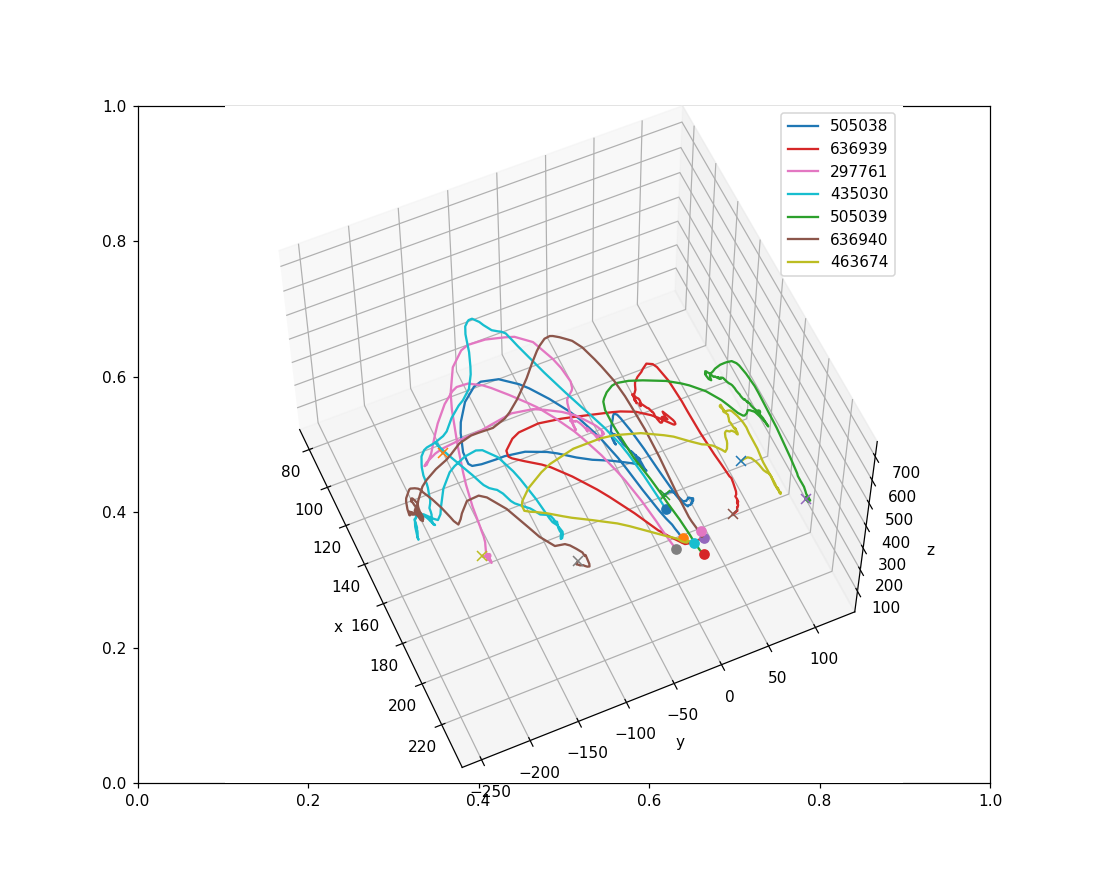

In [407]:
# import pickle
# from itertools import combinations

# def homogenous_transform(R,vect):

#     '''
#     :param R: 3x3 matrix
#     :param vect: list x,y,z
#     :return:Homogenous transformation 4x4 matrix using R and vect
#     '''

#     H = np.zeros((4,4))
#     H[0:3,0:3] = R
#     frame_displacement = vect + [1]
#     D = np.array(frame_displacement)
#     D.shape = (1,4)
#     H[:,3] = D
#     return H

# def inverse_homogenous_transform(H):

#     '''
#     :param H: Homogenous Transform Matrix
#     :return: Inverse Homegenous Transform Matrix
#     '''


#     R = H[0:3,0:3]
#     origin = H[:-1,3]
#     origin.shape = (3,1)

#     R = R.T
#     origin = -R.dot(origin)
#     return homogenous_transform(R,list(origin.flatten()))

# def rigid_transform_3D(A, B):
#     assert A.shape == B.shape

#     num_rows, num_cols = A.shape
#     if num_rows != 3:
#         raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

#     num_rows, num_cols = B.shape
#     if num_rows != 3:
#         raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

#     # find mean column wise
#     centroid_A = np.mean(A, axis=1)
#     centroid_B = np.mean(B, axis=1)

#     # ensure centroids are 3x1
#     centroid_A = centroid_A.reshape(-1, 1)
#     centroid_B = centroid_B.reshape(-1, 1)

#     # subtract mean
#     Am = A - centroid_A
#     Bm = B - centroid_B

#     H = Am @ np.transpose(Bm)

#     # sanity check
#     #if linalg.matrix_rank(H) < 3:
#     #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

#     # find rotation
#     U, S, Vt = np.linalg.svd(H)
#     R = Vt.T @ U.T

# #     special reflection case
#     if np.linalg.det(R) < 0:
# #         print("det(R) < R, reflection detected!, correcting for it ...")
#         Vt[2,:] *= -1
#         R = Vt.T @ U.T

#     t = -R @ centroid_A + centroid_B

#     return R, t

# def get_HT_template_in_obj(template, obj_coord, camera_in_template):
#     idx = pd.IndexSlice
#     points_template = []
#     points_obj = []
#     if not isinstance(obj_coord, dict):
#         bps = obj_coord.index.get_level_values('bodyparts').unique()
#         for bodypart in bps:
#             df_bodypart = obj_coord.loc[bodypart]
#             if not df_bodypart.isnull().values.any():
#                 points_template.append(template[bodypart])
#                 points_obj.append(df_bodypart.to_numpy())
#     else:
#         keys = obj_coord.keys()
#         for bodypart in keys:
#             df_bodypart = df[bodypart]
#             if not df_bodypart.isnull().values.any():
#                 points_template.append(template[bodypart])
#                 points_obj.append(df_bodypart.to_numpy())
                
#     points_template = np.array(points_template).T
#     points_obj = np.array(points_obj).T
    
#     points_template_in_template = camera_in_template @ homogenous_position(points_template)
#     points_obj_in_template = camera_in_template @ homogenous_position(points_obj)
#     rotmatrix, translation = rigid_transform_3D(points_obj_in_template[:3,:], points_template_in_template[:3,:])
#     H = homogenous_transform(rotmatrix, list(translation.flatten()))
    
#     points_obj_transformed = (H @ points_obj_in_template).T
#     dists = []
#     for i, point in enumerate(points_obj_transformed):
#         point = point[:3]
#         dist = np.linalg.norm(point[:3] - points_template_in_template[:-1,i])
#         dists.append(dist)
#     dist_average = np.mean(np.array(dists), axis=0)
# #     print(f'distances : {dists}')
# #     print(f'average distance: {dist_average}')
#     return H, dist_average


# def homogenous_position(vect):
#     temp = np.array(vect)
#     if temp.ndim == 1:
#         ones = np.ones(1)
#         return np.r_[temp, ones].reshape(-1, 1)
#     elif temp.ndim == 2:
        
#         num_rows, num_cols = temp.shape
#         if num_rows != 3:
#             raise Exception(f"vect is not 3 * N, it is {num_rows}x{num_cols}")

#         ones = np.ones(num_cols).reshape(1,-1)
#         return np.r_[temp, ones]

# def get_obj_coord_median(df_individual, window_size = 10):
#     bps = df_individual.columns.get_level_values('bodyparts').unique()
#     obj_coord = {}
#     for bp in bps:
#         obj_coord[bp] = df_individual[bp].iloc[:window_size].median()
#     return obj_coord


# template_dir = f'/home/luke/Desktop/project/make_tea/Process_data/postprocessed/2022-05-26/transformations/{triangulation}'

# with open(os.path.join(template_dir, 'obj_templates.pickle'), "rb") as f:
#     obj_templates = pickle.load(f)

# with open(os.path.join(template_dir, 'camera_to_ndi.pickle'), "rb") as f:
#     camera_in_ndi = pickle.load(f)
    
# with open(os.path.join(template_dir, 'ndi_to_camera.pickle'), "rb") as f:
#     ndi_in_camera = pickle.load(f)

# individual = 'tap'
# if 'teabag' in individual:
#     obj = 'teabag'
# else:
#     obj = individual

# obj_template = obj_templates[obj]
# rot_matrix = ndi_in_camera[:3,:3]


# markers = []
# for bp in obj_template:
#     markers.append(obj_template[bp])
# markers = np.array(markers)
# center = np.mean(markers, axis=0)
# template_in_camera = homogenous_transform(rot_matrix, list(center))
# camera_in_template = inverse_homogenous_transform(template_in_camera)

# fig,ax = plt.subplots(1,1, figsize = (10,8))
# ax = plt.axes(projection='3d')
# idx = pd.IndexSlice
# bad_demos = ['463678', '636936', '636938', '463675']
# '''
# '463678', '636936': mislabeled teabag1
# '636938', '463675': starting point far from other demos
# '''

# window_size = 20
# n_marker = 3
# dists = {}

# for demo in obj_trajs_in_camera:
#     dist = np.inf
#     for i in range(window_size):
#         marker_coords = obj_trajs_in_camera_full[demo][individual].iloc[i]
#         bps = marker_coords.index.get_level_values('bodyparts').unique()
#         combs = combinations(bps, n_marker)
#         for comb in combs:
#             partial_marker_coords = marker_coords.loc[list(comb)]
#             if partial_marker_coords.isnull().any():
#                 continue
#             H, dist_average = get_HT_template_in_obj(obj_template, partial_marker_coords, camera_in_template)
#             if dist_average < dist:
#                 dist = dist_average
#                 template_in_obj = H
                
#     dists[demo] = dist
#     if dist > 20:
#         bad_demos.append(demo)
#     if demo in bad_demos:
#         continue
#     gripper_traj = gripper_trajs_in_ndi[demo].loc[:,['x', 'y', 'z']].to_numpy()
#     obj_in_template = inverse_homogenous_transform(template_in_obj)
#     obj_in_camera = template_in_camera @ obj_in_template
#     obj_in_ndi = camera_in_ndi @ obj_in_camera
#     obj_in_ndi[:3, :3] = np.eye(3)
#     ndi_in_obj = inverse_homogenous_transform(obj_in_ndi)
# #     gripper_in_obj = gripper_traj - obj_in_ndi[:-1,3]
#     gripper_in_obj = (ndi_in_obj @ homogenous_position(gripper_traj.T)).T
    
#     ax.plot(gripper_in_obj[:, 0], gripper_in_obj[:, 1], gripper_in_obj[:, 2], label = f'{demo}')
#     ax.plot(gripper_in_obj[0, 0], gripper_in_obj[0, 1], gripper_in_obj[0, 2], 'o')
#     ax.plot(gripper_in_obj[-1, 0], gripper_in_obj[-1, 1], gripper_in_obj[-1, 2], 'x')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.legend()